In [1]:
window_size = [14,30,60,90,180]
num_features = 56 #depends on how much features we have
output_days = 7
output_features = 2 #min and max

Base Model building

In [2]:
import tensorflow as tf
from tensorflow.keras import layers,models

In [3]:
# Time-weighted loss function definition
# Custom Time-Weighted Loss Function
# Custom Keras Loss Class
class TimeWeightedLoss(tf.keras.losses.Loss):
    def __init__(self, weights, lambda_=1.0, gamma=0.1, name="time_weighted_loss"):
        super().__init__(name=name)
        self.weights = tf.convert_to_tensor(weights, dtype=tf.float32)
        self.lambda_ = lambda_
        self.gamma = gamma

    def call(self, y_true, y_pred):
        # Split y_true and y_pred into min and max
        y_true_min, y_true_max = y_true[:, :, 1], y_true[:, :, 0]
        y_pred_min, y_pred_max = y_pred[:, :, 1], y_pred[:, :, 0]

        # Ensure weights are properly shaped
        weights = tf.reshape(self.weights, [1, 7])  # Shape for broadcasting

        # Time-weighted MSE for min and max
        mse_min = tf.reduce_mean(weights * tf.square(y_true_min - y_pred_min))
        mse_max = tf.reduce_mean(weights * tf.square(y_true_max - y_pred_max))

        # Time-weighted min-max constraint penalty
        penalty = tf.reduce_sum(weights * tf.square(tf.maximum(0.0, y_pred_min - y_pred_max)))

        # Time-weighted temporal smoothness
        smoothness_min = tf.reduce_sum(weights[:, 1:] * tf.square(y_pred_min[:, 1:] - y_pred_min[:, :-1]))
        smoothness_max = tf.reduce_sum(weights[:, 1:] * tf.square(y_pred_max[:, 1:] - y_pred_max[:, :-1]))

        # Total loss
        total_loss = (mse_min + mse_max) + self.lambda_ * penalty + self.gamma * (smoothness_min + smoothness_max)
        return total_loss

    def get_config(self):
        return {"weights": self.weights.numpy().tolist(), "lambda_": self.lambda_, "gamma": self.gamma}

# Define weights (e.g., exponential decay)
alpha = 0.7
weights = [alpha ** (d - 1) for d in range(1, 8)]

# Instantiate the custom loss
custom_loss = TimeWeightedLoss(weights=weights, lambda_=1.0, gamma=0.1)


In [4]:
def baseline_LSTM_model(window_size, num_features, output_days, output_features):
    inputs = layers.Input(shape=(window_size, num_features))
    
    x = layers.LSTM(100, return_sequences=True)(inputs)
    x = layers.LSTM(100)(x)
    
    x = layers.Dense(output_days * output_features)(x)  # Output for 7 days * 2 features (min and max)
    
    x = layers.Reshape((output_days, output_features))(x)
    
    model = models.Model(inputs, x)
    function_name = baseline_LSTM_model.__name__
    
    return model, function_name

In [5]:
def baseline_GRU_model(window_size, num_features, output_days, output_features):
    inputs = layers.Input(shape=(window_size, num_features))
    
    x = layers.GRU(100, return_sequences=False)(inputs)
    
    x = layers.Dense(output_days * output_features)(x)  # Output for 7 days * 2 features (min and max)
    
    x = layers.Reshape((output_days, output_features))(x)
    
    model = models.Model(inputs, x)
    function_name = baseline_GRU_model.__name__
    
    return model, function_name

In [6]:
'''
CNN_LSTM mdoel is a combination of CNN and LSTM. CNN is used to extract the features from the input data and LSTM is used to support the sequence data.
'''
def CNN_LSTM_model(window_size, num_features, output_days, output_features):
    inputs = layers.Input(shape=(window_size, num_features))
    
    x = layers.Conv1D(filters=64, kernel_size=2, activation='relu')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(filters=128, kernel_size=2, activation='relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    
    x = layers.LSTM(100, return_sequences=True)(x)
    x = layers.LSTM(100)(x)
    
    x = layers.Dense(output_days * output_features)(x)  # 7 days * 2 targets (High, Low)
    
    x = layers.Reshape((output_days, output_features))(x)
    
    model = models.Model(inputs, x)
    function_name = CNN_LSTM_model.__name__
    
    return model, function_name
#can use KAN, Attenion layer to adjust the weight

In [7]:
# Define the CNN + GRU model
def CNN_GRU_model(window_size, num_features, output_days, output_features):
    inputs = layers.Input(shape=(window_size, num_features))
    
    x = layers.Conv1D(filters=64, kernel_size=2, activation='relu')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(filters=128, kernel_size=2, activation='relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    
    x = layers.GRU(100, return_sequences=False)(x)
    
    x = layers.Dense(output_days * output_features)(x)  # Output for 7 days * 2 features (min and max)
    
    x = layers.Reshape((output_days, output_features))(x)
    
    model = models.Model(inputs, x)
    function_name = CNN_GRU_model.__name__
    
    return model, function_name

In [8]:
from tensorflow.keras.layers import Attention
def CNN_LSTM_SA_model(window_size, num_features, output_days, output_features):
    inputs = layers.Input(shape=(window_size, num_features))
    x = layers.Conv1D(filters=64, kernel_size=2, activation='relu')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(filters=128, kernel_size=2, activation='relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.LSTM(100, return_sequences=True)(x)
    x = layers.LSTM(100, return_sequences=True)(x)
    
    # Attention mechanism
    attention = Attention()([x, x])
    x = layers.Concatenate()([x, attention])
    x = layers.GlobalAveragePooling1D()(x)
    
    x = layers.Dense(output_days*output_features)(x)
    outputs = layers.Reshape((output_days, output_features))(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    function_name = CNN_LSTM_SA_model.__name__
    return model, function_name

In [9]:
def CNN_GRU_SA_model(window_size, num_features, output_days, output_features):
    inputs = layers.Input(shape=(window_size, num_features))
    
    x = layers.Conv1D(filters=64, kernel_size=2, activation='relu')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(filters=128, kernel_size=2, activation='relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    
    x = layers.GRU(100, return_sequences=True)(x)
    
    attention = layers.Attention()([x, x])  # Self-attention (query = value = x)
    x = layers.Concatenate()([x, attention])
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(output_days * output_features)(x)
    
    outputs = layers.Reshape((output_days, output_features))(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    function_name = CNN_GRU_SA_model.__name__
    
    return model,function_name

In [10]:
def get_angles(pos, i, d_model):
    """Helper function to compute the angles for positional encoding."""
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

In [11]:
import numpy as np

def positional_encoding(seq_len, d_model):
    """
    Computes the sinusoidal positional encoding.

    Args:
        seq_len (int): Length of the sequence.
        d_model (int): Dimensionality of the model.

    Returns:
        tf.Tensor: Positional encoding of shape (1, seq_len, d_model).
    """
    pos = np.arange(seq_len)[:, np.newaxis]
    i = np.arange(d_model)[np.newaxis, :]
    angle_rads = get_angles(pos, i, d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

In [12]:
def transformer_encoder(inputs, d_model, num_heads, ff_dim, dropout_rate):
    """
    Implements a single transformer encoder block.

    Args:
        inputs (tf.Tensor): Input tensor of shape (batch_size, seq_len, d_model).
        d_model (int): Dimensionality of the model.
        num_heads (int): Number of attention heads.
        ff_dim (int): Dimensionality of the feed-forward network.
        dropout_rate (float): Dropout rate.

    Returns:
        tf.Tensor: Output tensor of the encoder block.
    """
    # Multi-head self-attention
    attn_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(inputs, inputs)
    attn_output = tf.keras.layers.Dropout(dropout_rate)(attn_output)
    out1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attn_output)
    
    # Feed-forward network
    ffn_output = tf.keras.layers.Dense(ff_dim, activation='relu')(out1)
    ffn_output = tf.keras.layers.Dense(d_model)(ffn_output)
    ffn_output = tf.keras.layers.Dropout(dropout_rate)(ffn_output)
    out2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(out1 + ffn_output)
    
    return out2

In [13]:
def TFT_transformer_model(window_size, num_features, output_days, output_features,
                            d_model=64, num_heads=4, ff_dim=128, num_transformer_blocks=2, dropout_rate=0.1):
    """
    Builds a simplified Temporal Fusion Transformer (TFT)-inspired model for stock prediction.
    
    Args:
        window_size (int): Number of time steps in the input sequence.
        num_features (int): Number of features per time step.
        output_days (int): Number of days (time steps) to predict.
        output_features (int): Number of features to predict per day.
        d_model (int, optional): Dimensionality of the model. Default is 64.
        num_heads (int, optional): Number of attention heads in the transformer blocks. Default is 4.
        ff_dim (int, optional): Dimensionality of the feed-forward network. Default is 128.
        num_transformer_blocks (int, optional): Number of transformer encoder blocks. Default is 2.
        dropout_rate (float, optional): Dropout rate. Default is 0.1.
        
    Returns:
        tf.keras.Model: A compiled Keras model ready for training.
    """
    inputs = tf.keras.Input(shape=(window_size, num_features))
    x = tf.keras.layers.Dense(d_model)(inputs)
    pos_encoding = positional_encoding(window_size, d_model)
    x = x + pos_encoding
    
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, d_model, num_heads, ff_dim, dropout_rate)
    
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(output_days * output_features)(x)
    outputs = tf.keras.layers.Reshape((output_days, output_features))(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    function_name = TFT_transformer_model.__name__
    # Return the model along with a name for saving/identification
    return model, function_name

Meta Model training 

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from tensorflow.keras.models import save_model

def base_training(model_function,
                loading_path, 
                saving_path, 
                version_name, 
                seed = 42,
                test_size = 0.8,
                epochs = 20,
                batch_size = 8,
                shuffle=True, 
                metrics=['mae'],
                loss = 'mean_squared_error',
                #loss = custom_loss,
                optimizer='adam',
                window_size = window_size, 
                num_features = num_features, 
                output_days = output_days, 
                output_features = output_features):
    
    model_history = []
    models = []
    X_tests = []
    y_tests = []
    #create folder to save the model
    if loss == custom_loss:
        model_folder_path = os.path.join(saving_path, version_name, f"_s-{seed}_t-{test_size}_e-{epochs}_b-{batch_size}_S-{shuffle}_m-{metrics}_l-custom_o-{optimizer}")
    else:
        model_folder_path = os.path.join(saving_path, version_name, f"_s-{seed}_t-{test_size}_e-{epochs}_b-{batch_size}_S-{shuffle}_m-{metrics}_l-{loss}_o-{optimizer}")

    os.makedirs(model_folder_path, exist_ok=True)
    print(f"Folder '{version_name}' is ready.")


    for window in window_size:
        # Load the data
        X = pd.read_pickle(loading_path + f"X_{window}days_i.pkl")
        y = pd.read_pickle(loading_path + f"y_{window}days_i.pkl")
        print(f"Data for {window} days loaded.")

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, 
                                                            y, 
                                                            test_size=test_size, 
                                                            shuffle=shuffle, 
                                                            random_state=seed)
        print("Data split into training and testing sets.")

        # Train the model
        print("start training:\n")
        model, name = model_function(window, 
                                     num_features, 
                                     output_days, 
                                     output_features)
        model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        
        history = model.fit(X_train, 
                            y_train, 
                            epochs=epochs, 
                            batch_size=batch_size, 
                            validation_data=(X_test, y_test), 
                            verbose=1)
        
        # Save the model    
        model_save_path = os.path.join(model_folder_path, f"{name}_{window}days.h5")
        model.save(model_save_path)
        print(f"Model trained on {window} days has been saved.")
        models.append(model)
        model_history.append(history)
        X_tests.append(X_test)
        y_tests.append(y_test)

    return models, model_history, name, X_tests, y_tests
    

In [15]:
import matplotlib.pyplot as plt
def plot_training_history(model_history, window_size, name):
    for i, history in enumerate(model_history):
        plt.figure(figsize=(14, 7))
        plt.plot(history.history['loss'], label='Training Loss', color='blue')
        plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
        plt.title(f'Model Loss for {name} {window_size[i]} Days')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()
        plt.show()
    #plot prediction vs true value
    


In [16]:
#plot prediction vs true value
def plot_predictions(model_history, X_tests, y_tests, window_size, name):
    for id in range(len(model_history)):
        y_pred = model_history[id].predict(X_tests[id])
        days = range(1, output_days + 1)
        
        for i in range(0, len(y_pred), 1000):
            plt.figure(figsize=(14, 7))
            plt.plot(days, y_tests[id][i, :, 0], marker='o', label='True Min', color='blue')
            plt.plot(days, y_pred[i, :, 0], marker='o', label='Predicted Min', color='red')
            plt.plot(days, y_tests[id][i, :, 1], marker='o', label='True Max', color='green')
            plt.plot(days, y_pred[i, :, 1], marker='o', label='Predicted Max', color='orange')
            plt.title(f'Min and Max Predictions for {name} {window_size[id]} Days')
            plt.ylabel('Price')
            plt.xlabel('Day')
            plt.legend()
            plt.show()


Folder '20250204' is ready.
Data for 14 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 895.1517 - mae: 28.2823 - val_loss: 329.7523 - val_mae: 14.5197
Epoch 2/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 239.5216 - mae: 12.0781 - val_loss: 195.7143 - val_mae: 10.0716
Epoch 3/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 188.2824 - mae: 9.7738 - val_loss: 183.8684 - val_mae: 9.8165
Epoch 4/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 175.0577 - mae: 9.4497 - val_loss: 183.0956 - val_mae: 9.8543
Epoch 5/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 168.8484 - mae: 9.3087 - val_loss: 183.0467 - val_mae: 9.8650
Epoch 6/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 179.2630 - mae: 9.6830 - val_loss: 183.0489 - val_mae: 9.9027
Epoch 7/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 193.9899 - mae: 9.9085 - val_loss: 183.4745 - val_mae: 9.8289
Epoch 8/20
223/223 ━━━

Model trained on 14 days has been saved.
Data for 30 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 838.4885 - mae: 27.7495 - val_loss: 323.2439 - val_mae: 14.5174
Epoch 2/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 236.2202 - mae: 12.0343 - val_loss: 187.0585 - val_mae: 9.9811
Epoch 3/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 177.3891 - mae: 9.7933 - val_loss: 175.4630 - val_mae: 9.7109
Epoch 4/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 158.7457 - mae: 9.3005 - val_loss: 174.4291 - val_mae: 9.7358
Epoch 5/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 169.4814 - mae: 9.5348 - val_loss: 174.8581 - val_mae: 9.7174
Epoch 6/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 163.4765 - mae: 9.4251 - val_loss: 174.4507 - val_mae: 9.7333
Epoch 7/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 180.1530 - mae: 9.8126 - val_loss: 174.5148 - val_mae: 9.7294
Epoch 8/20

Model trained on 30 days has been saved.
Data for 60 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 824.7623 - mae: 27.8427 - val_loss: 304.6387 - val_mae: 14.5680
Epoch 2/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 218.8359 - mae: 12.0829 - val_loss: 170.6193 - val_mae: 9.8068
Epoch 3/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 185.2769 - mae: 9.7237 - val_loss: 159.2126 - val_mae: 9.4789
Epoch 4/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 142.2570 - mae: 9.0663 - val_loss: 158.2343 - val_mae: 9.4883
Epoch 5/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 171.0633 - mae: 9.6445 - val_loss: 158.4848 - val_mae: 9.4814
Epoch 6/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 136.4718 - mae: 9.0587 - val_loss: 158.0541 - val_mae: 9.5031
Epoch 7/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 168.0379 - mae: 9.7588 - val_loss: 158.2751 - val_mae: 9.4864
Epo

Model trained on 60 days has been saved.
Data for 90 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 17s 72ms/step - loss: 764.2434 - mae: 26.9715 - val_loss: 287.0748 - val_mae: 14.0790
Epoch 2/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 15s 68ms/step - loss: 229.4497 - mae: 11.9757 - val_loss: 159.8993 - val_mae: 9.6388
Epoch 3/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 15s 68ms/step - loss: 158.8000 - mae: 9.5729 - val_loss: 149.1072 - val_mae: 9.3366
Epoch 4/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 14s 66ms/step - loss: 142.1436 - mae: 9.0206 - val_loss: 148.3455 - val_mae: 9.3349
Epoch 5/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - loss: 139.8774 - mae: 9.1504 - val_loss: 148.1326 - val_mae: 9.3393
Epoch 6/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 14s 66ms/step - loss: 135.6909 - mae: 9.0294 - val_loss: 148.2936 - val_mae: 9.3359
Epoch 7/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 14s 67ms/step - loss: 143.4933 - mae: 9.2125 - val_loss: 148.4612 - val_mae: 9.3342
Epo

Model trained on 90 days has been saved.
Data for 180 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 29s 132ms/step - loss: 762.1867 - mae: 27.3539 - val_loss: 268.0145 - val_mae: 14.2732
Epoch 2/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 28s 133ms/step - loss: 213.6009 - mae: 12.3605 - val_loss: 133.7325 - val_mae: 9.3267
Epoch 3/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 27s 130ms/step - loss: 134.9601 - mae: 9.2825 - val_loss: 121.4009 - val_mae: 8.9070
Epoch 4/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 26s 125ms/step - loss: 122.0148 - mae: 9.0125 - val_loss: 120.8657 - val_mae: 8.9027
Epoch 5/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 26s 126ms/step - loss: 129.0197 - mae: 9.1463 - val_loss: 120.7732 - val_mae: 8.9050
Epoch 6/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 26s 124ms/step - loss: 133.4405 - mae: 9.0615 - val_loss: 121.1076 - val_mae: 8.9021
Epoch 7/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 26s 125ms/step - loss: 107.1709 - mae: 8.4919 - val_loss: 120.6634 - val_mae: 8.

Model trained on 180 days has been saved.


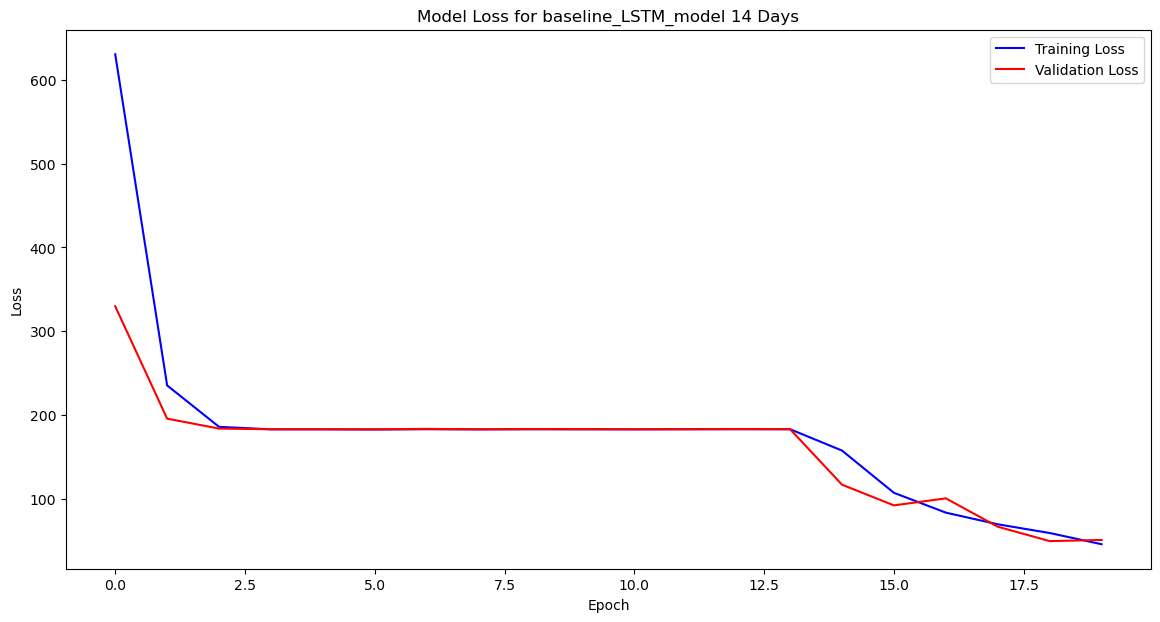

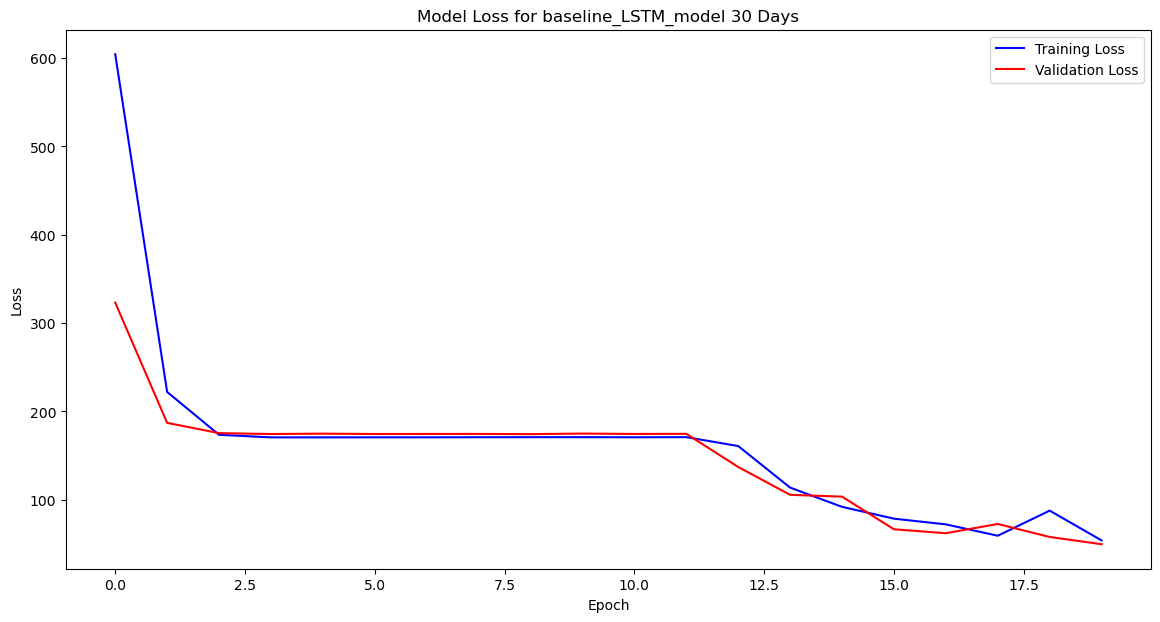

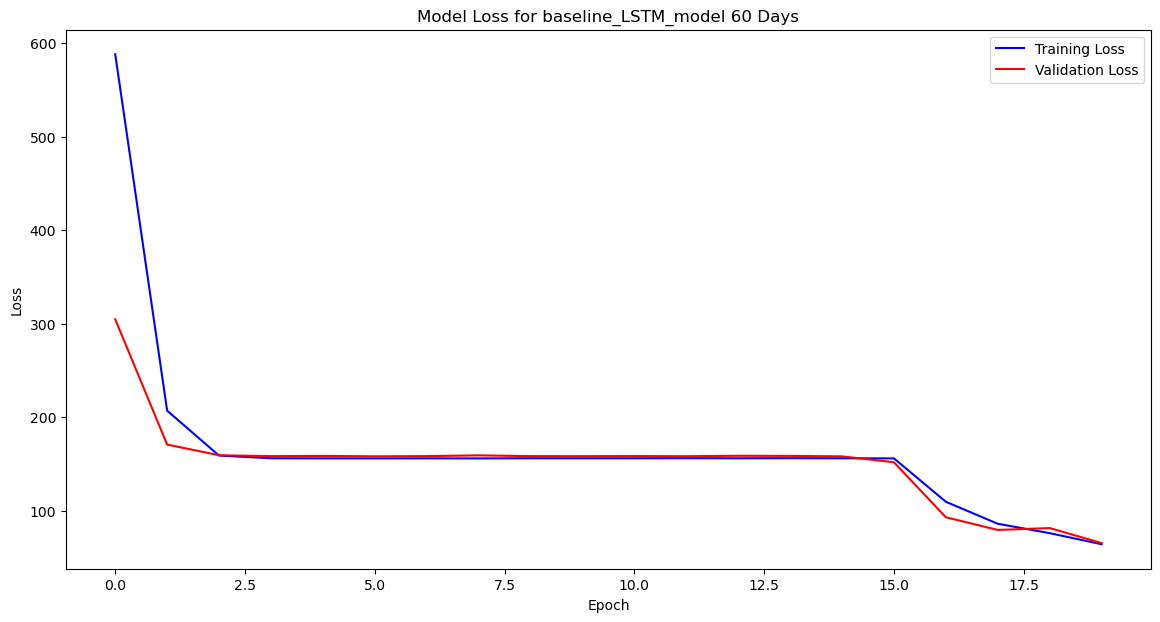

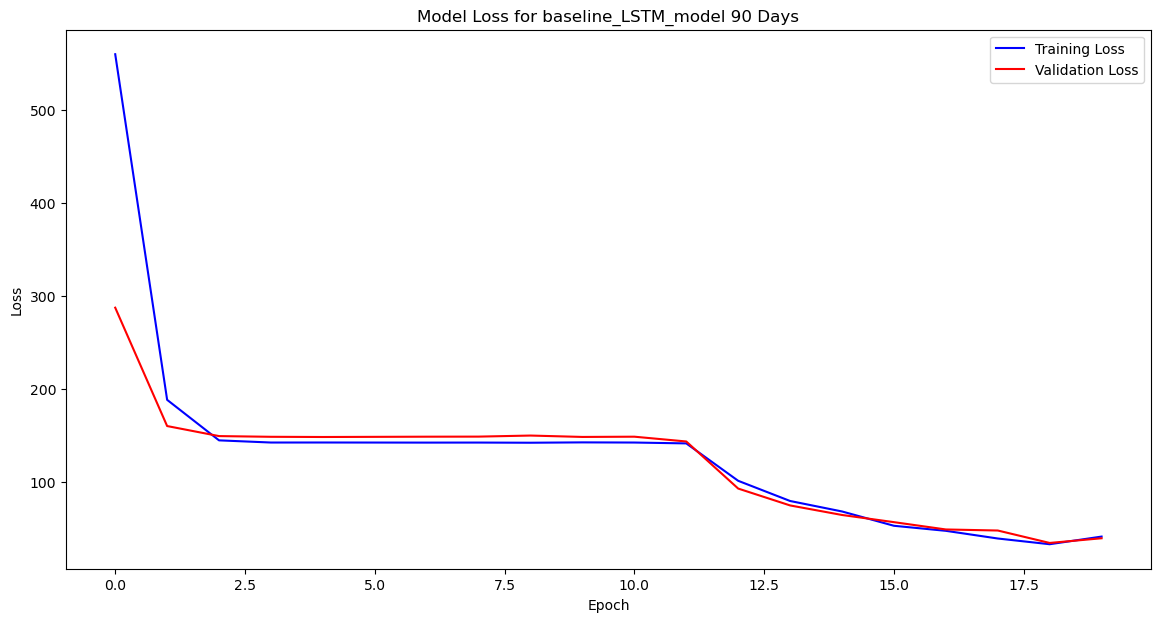

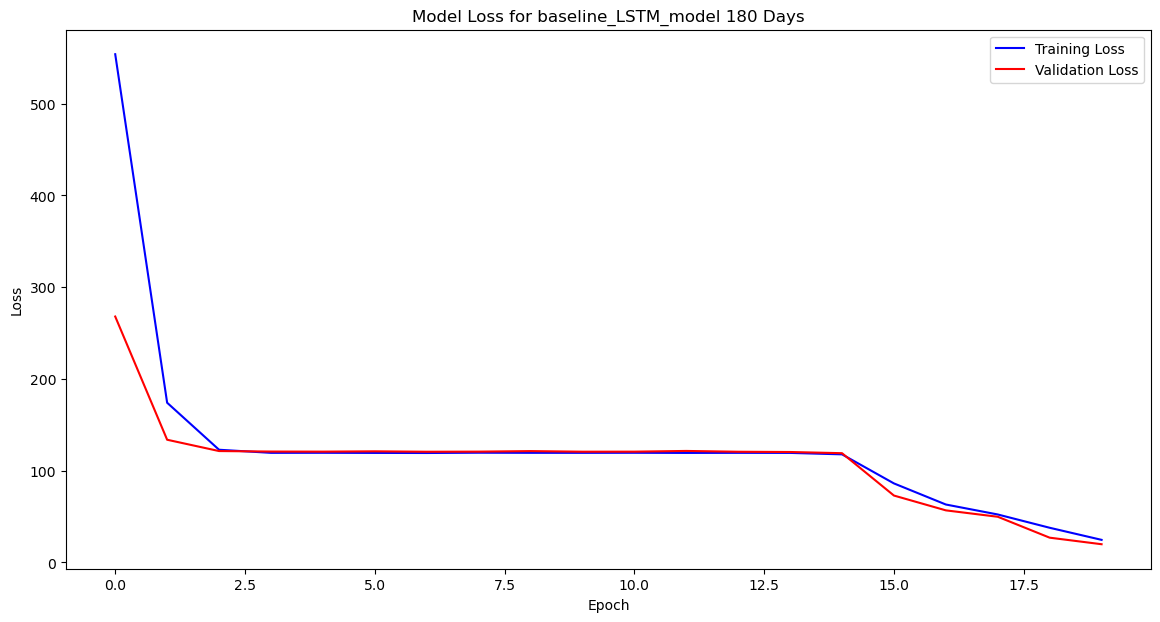

223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


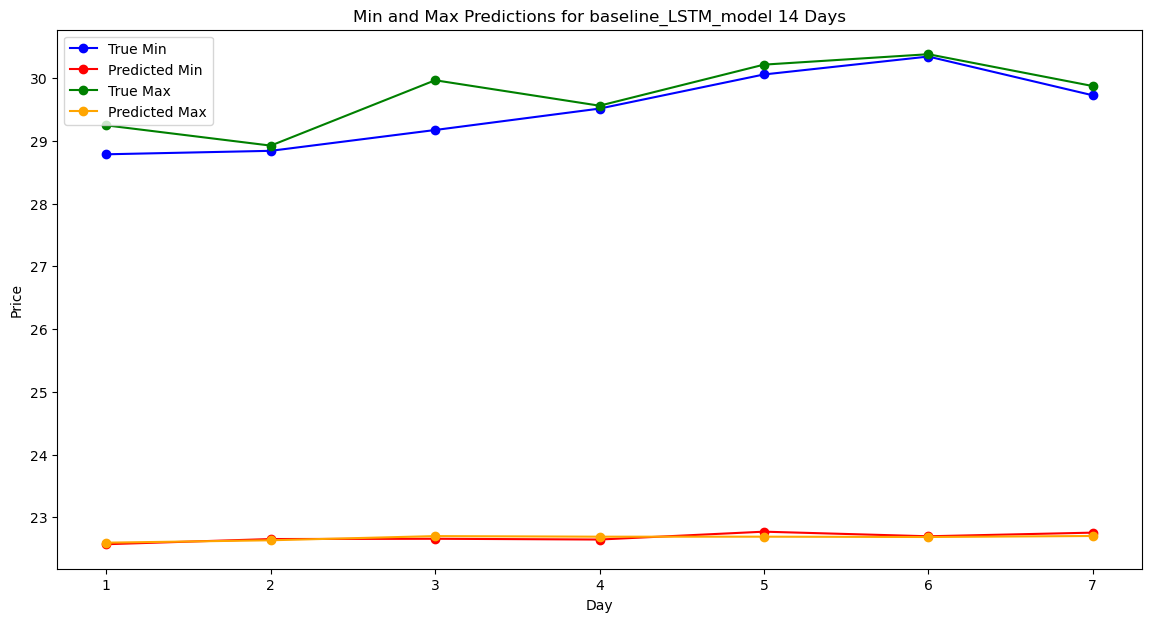

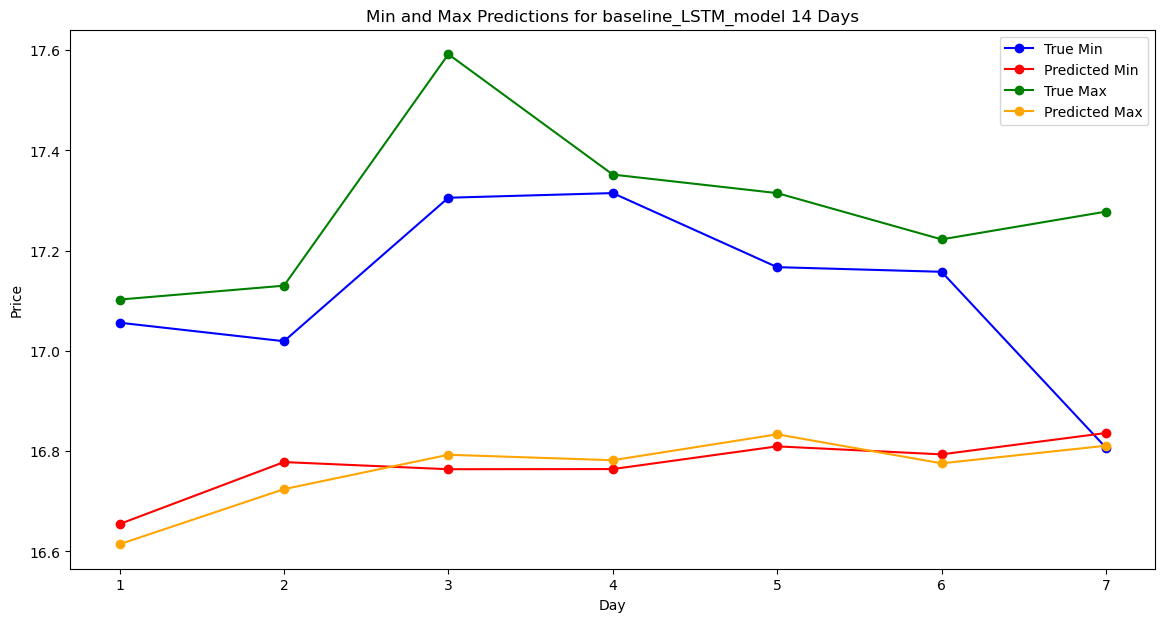

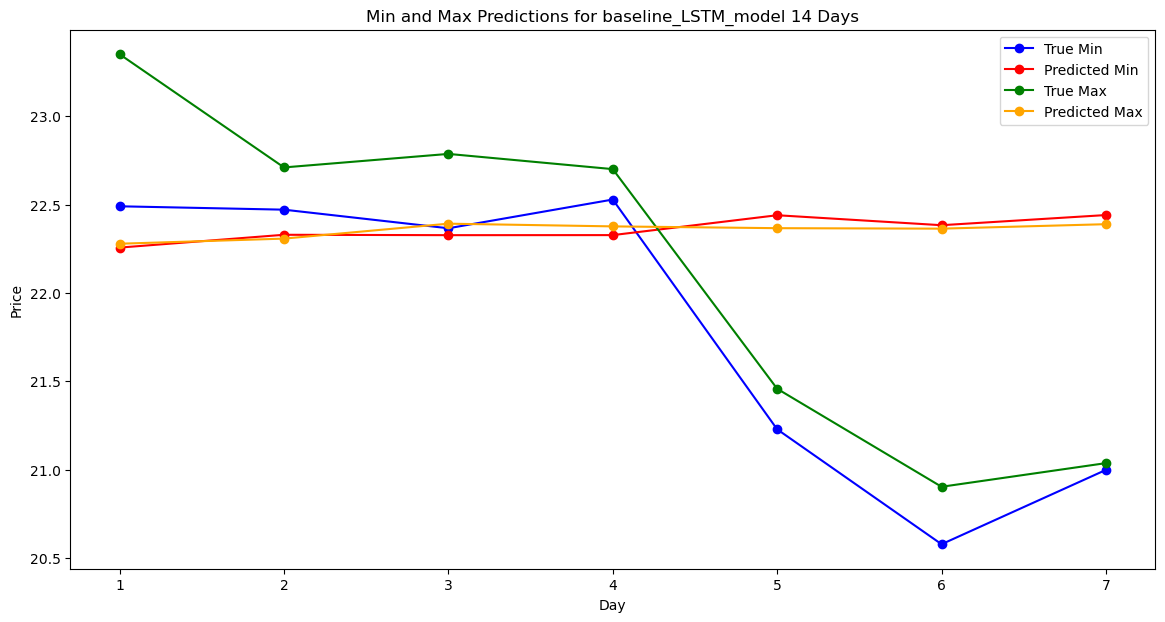

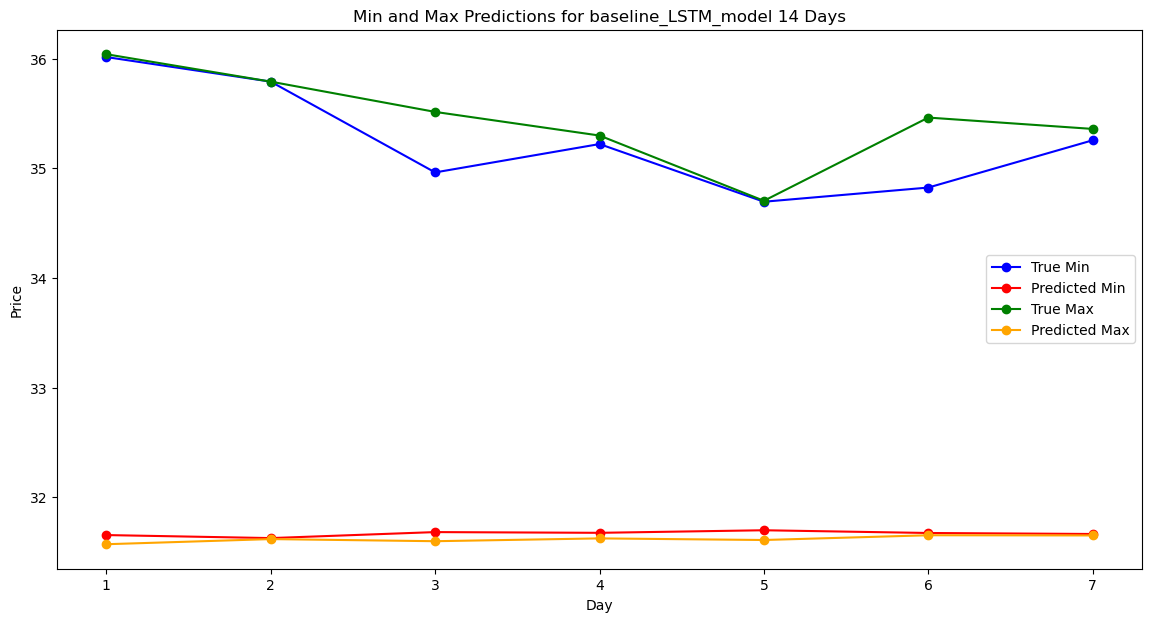

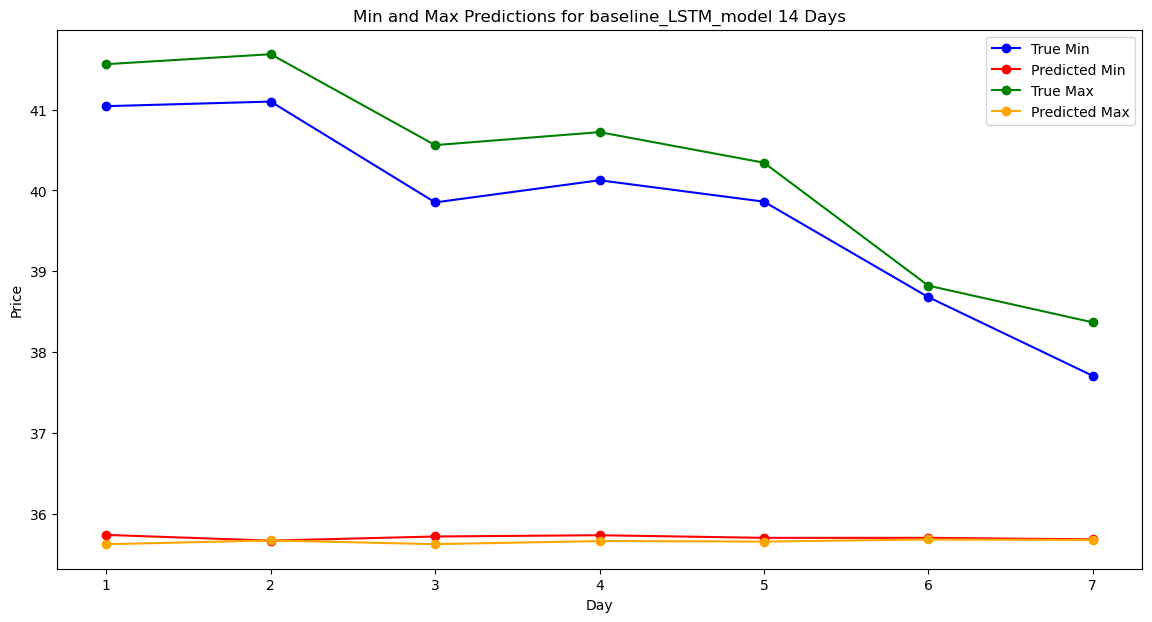

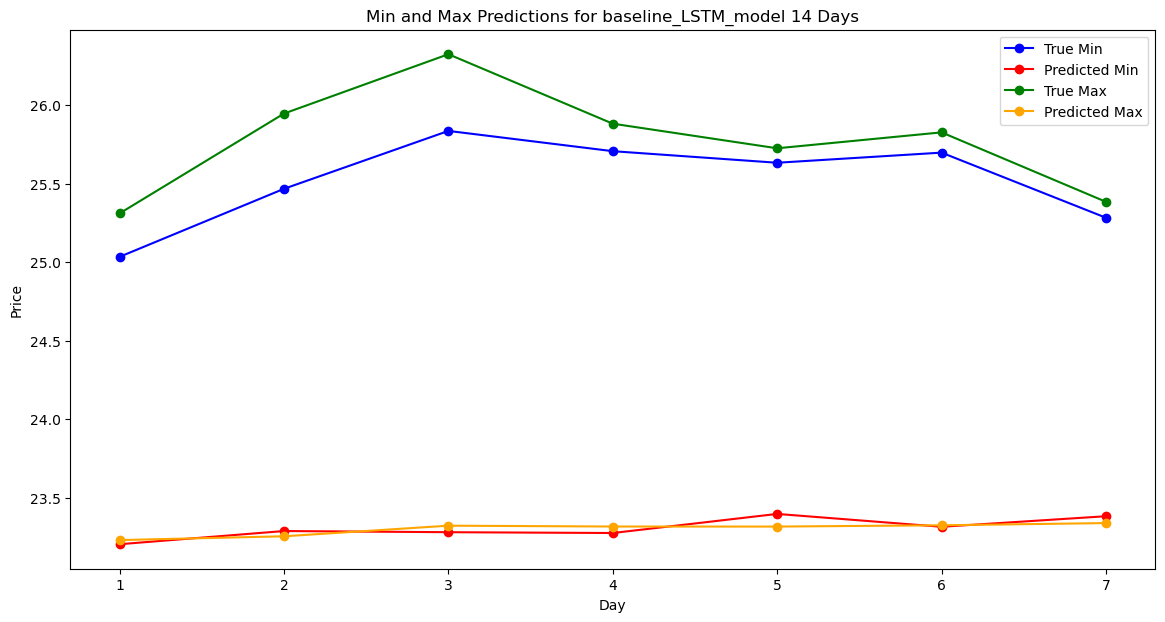

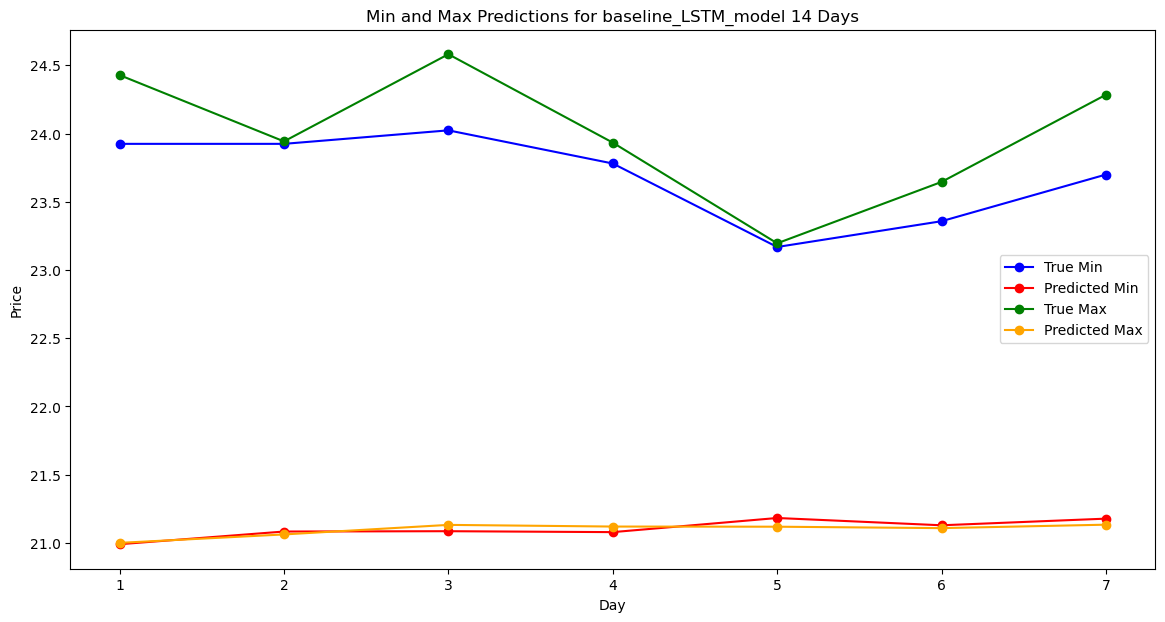

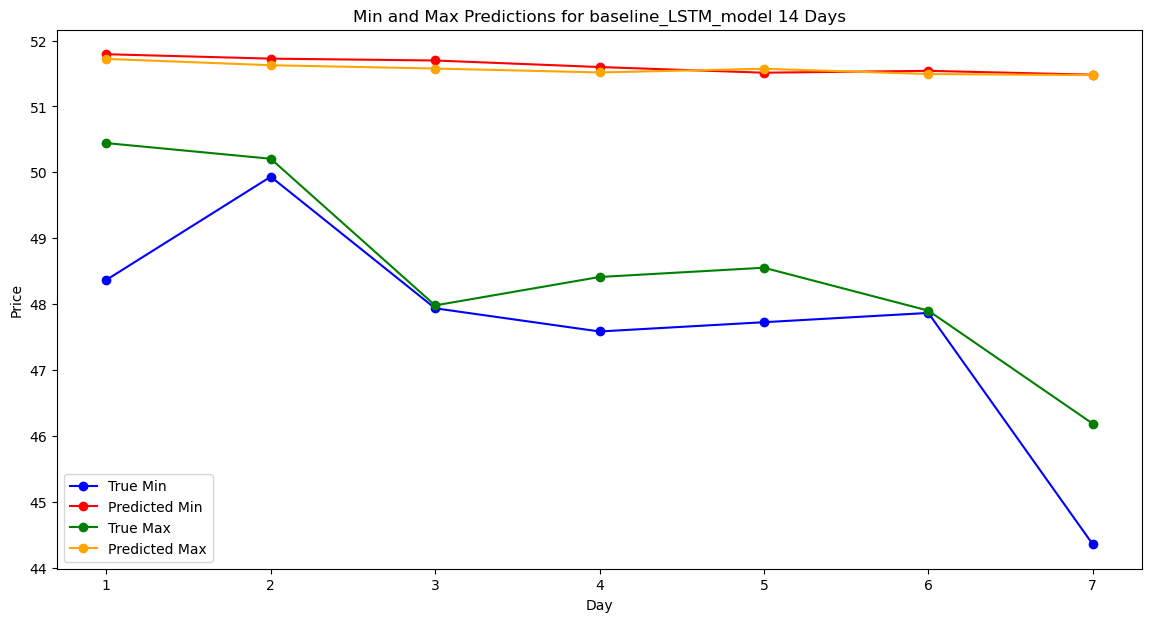

222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


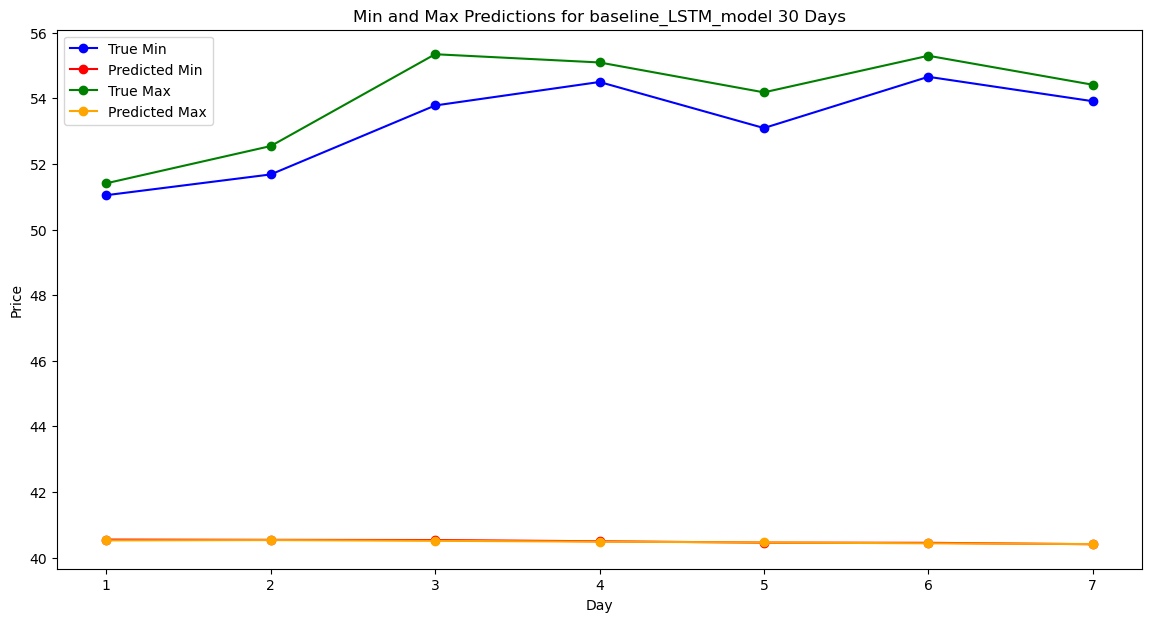

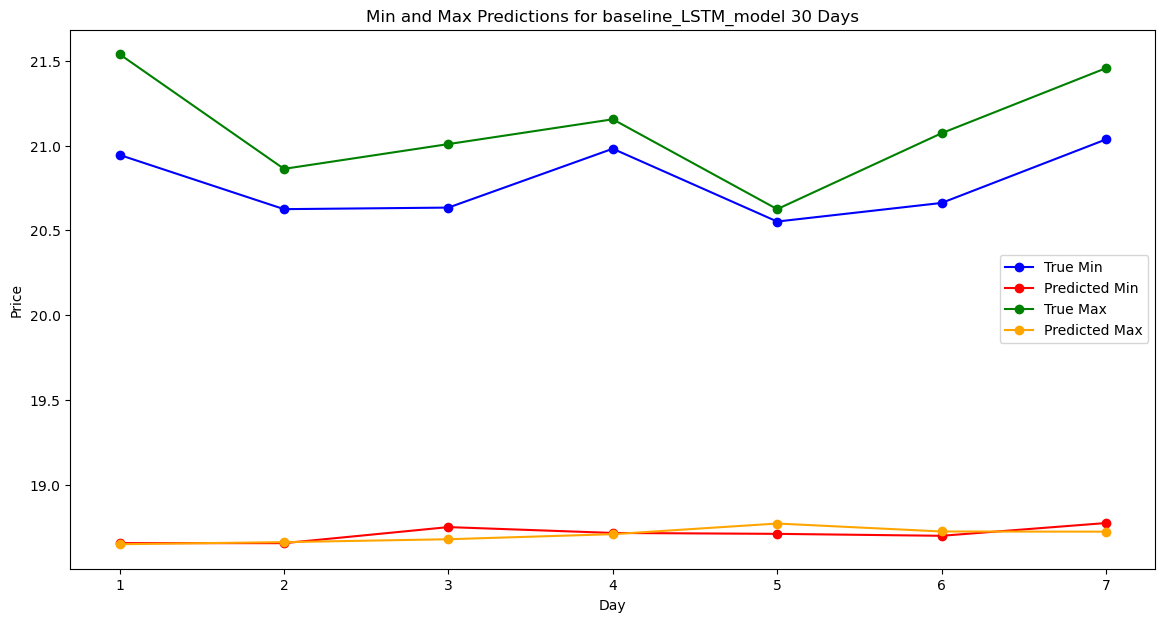

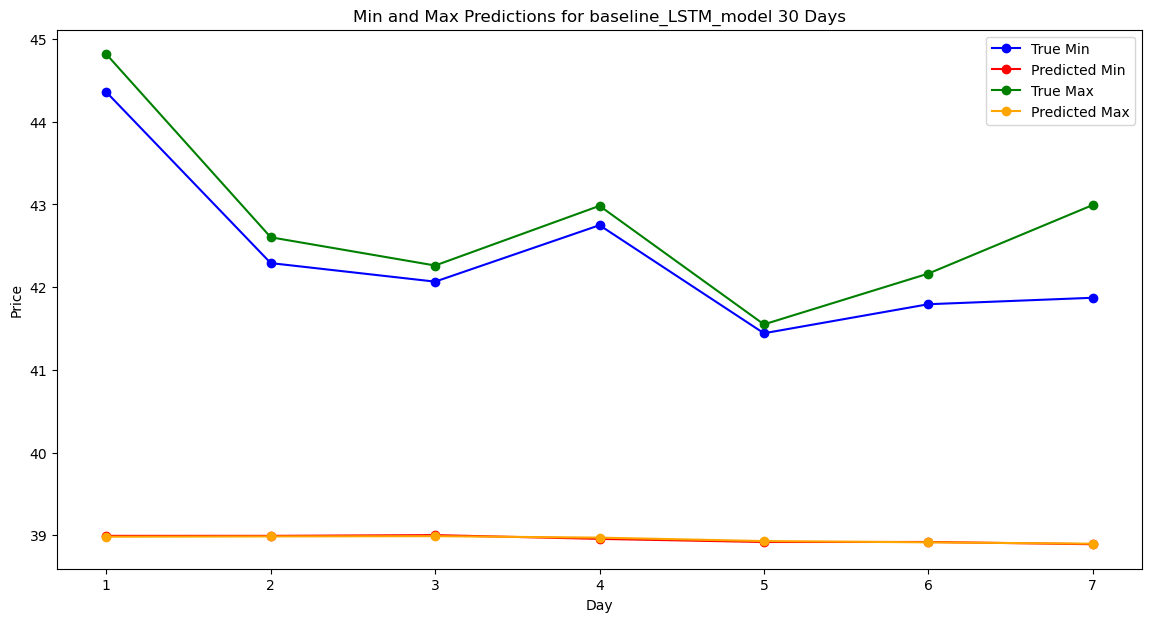

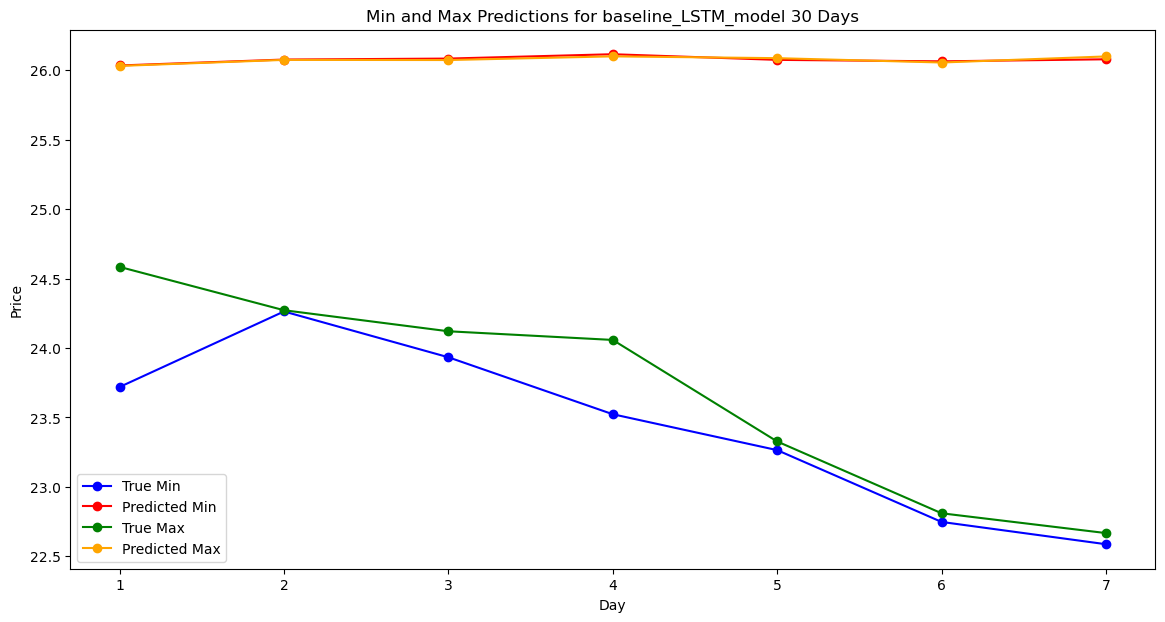

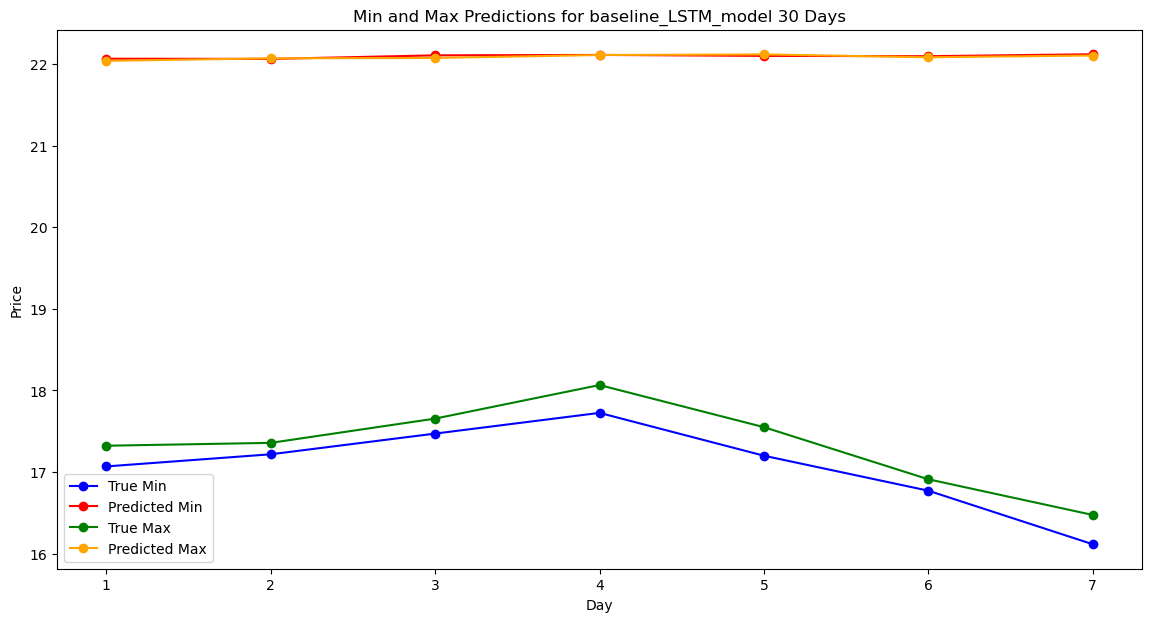

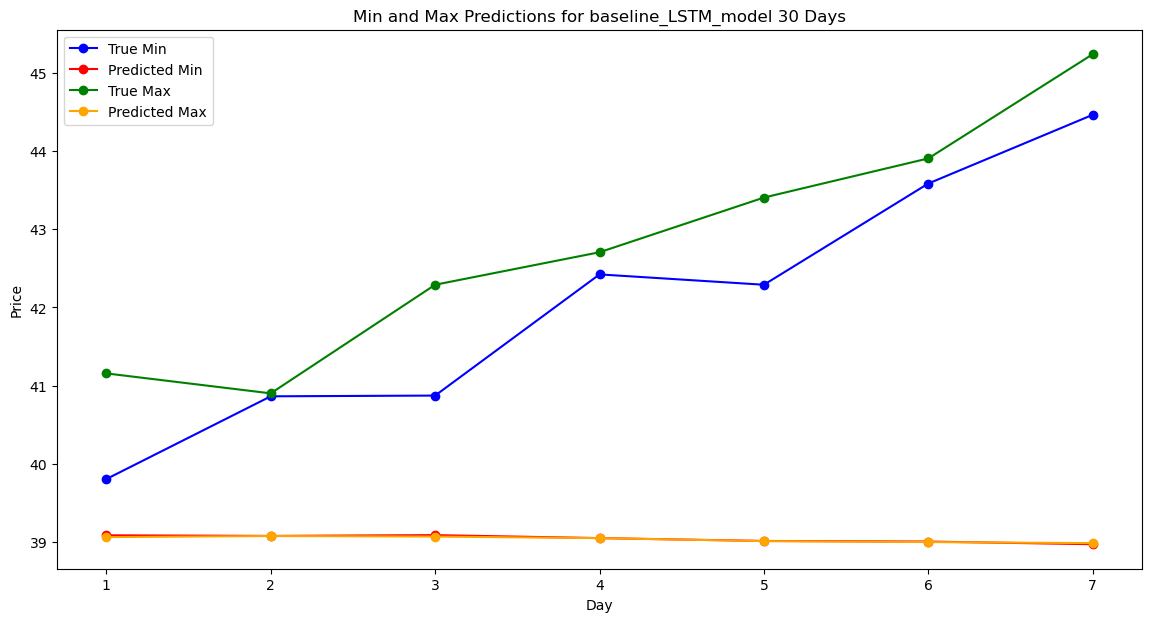

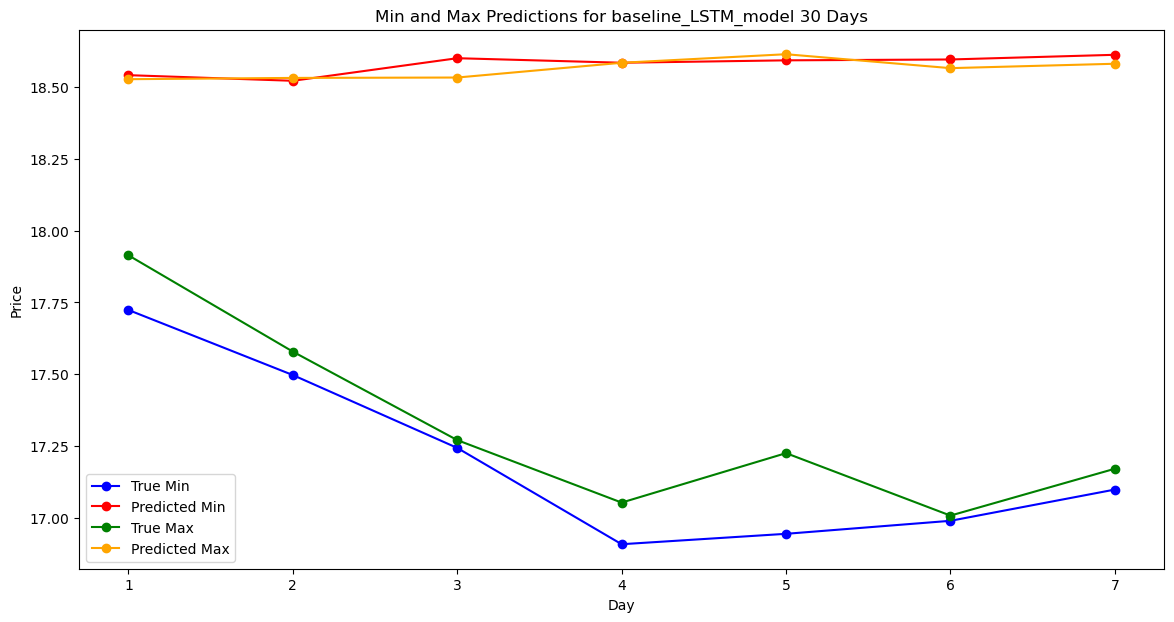

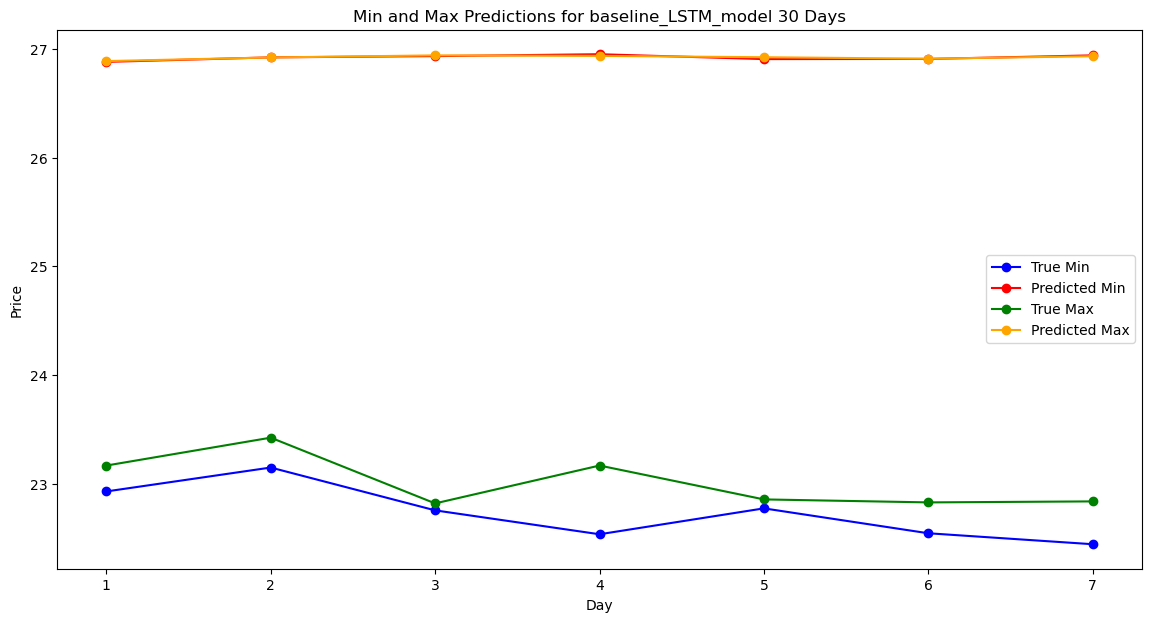

220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


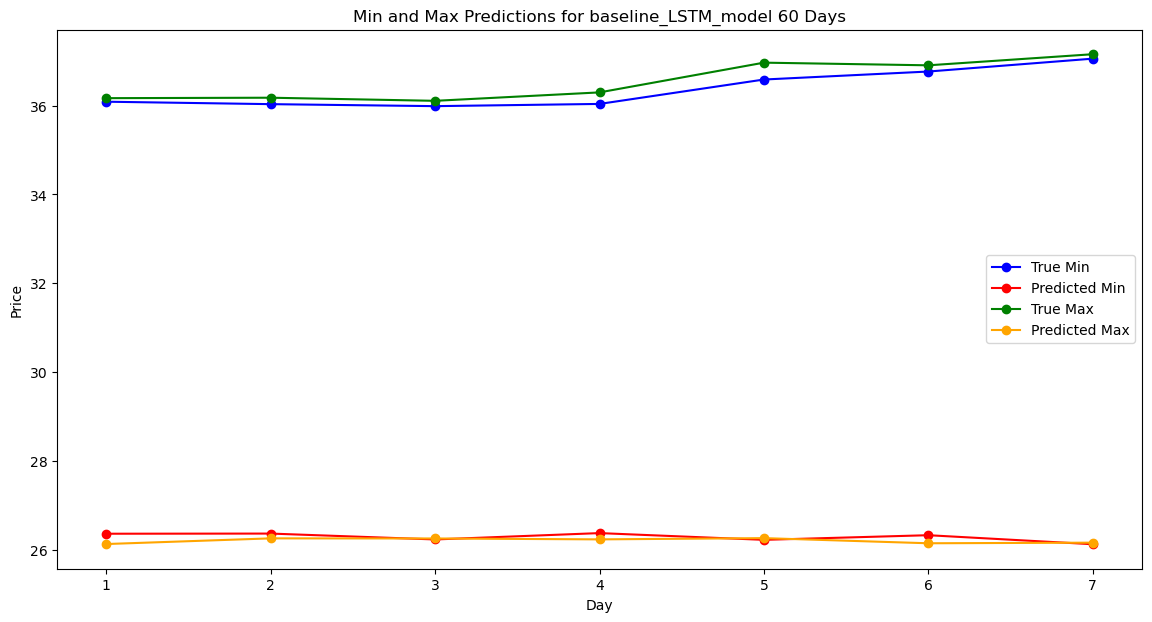

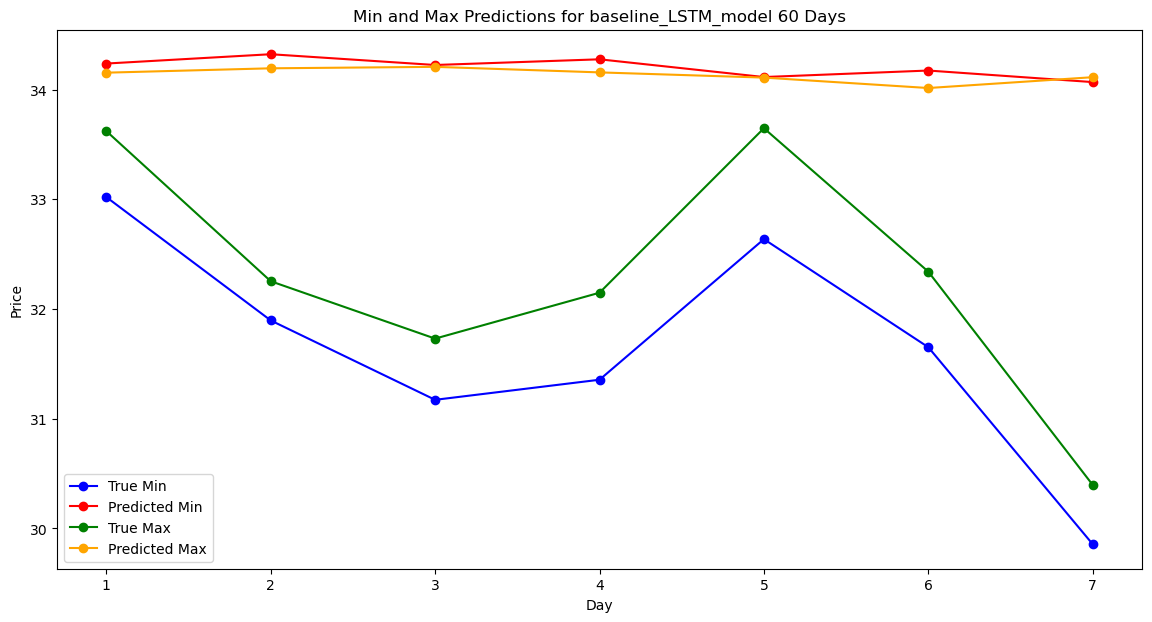

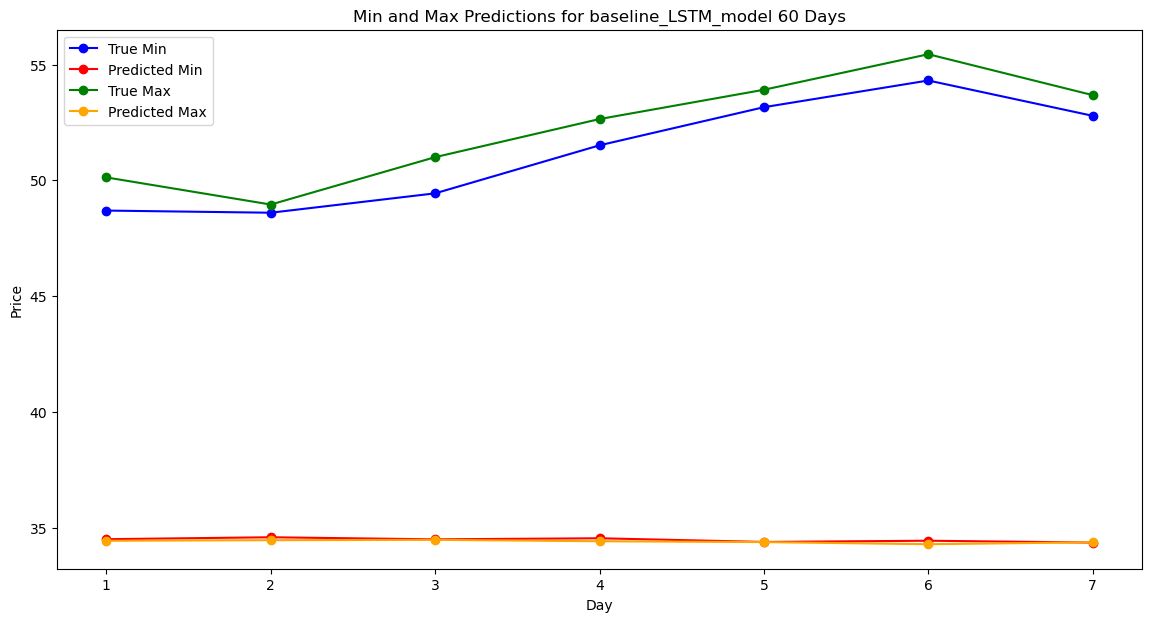

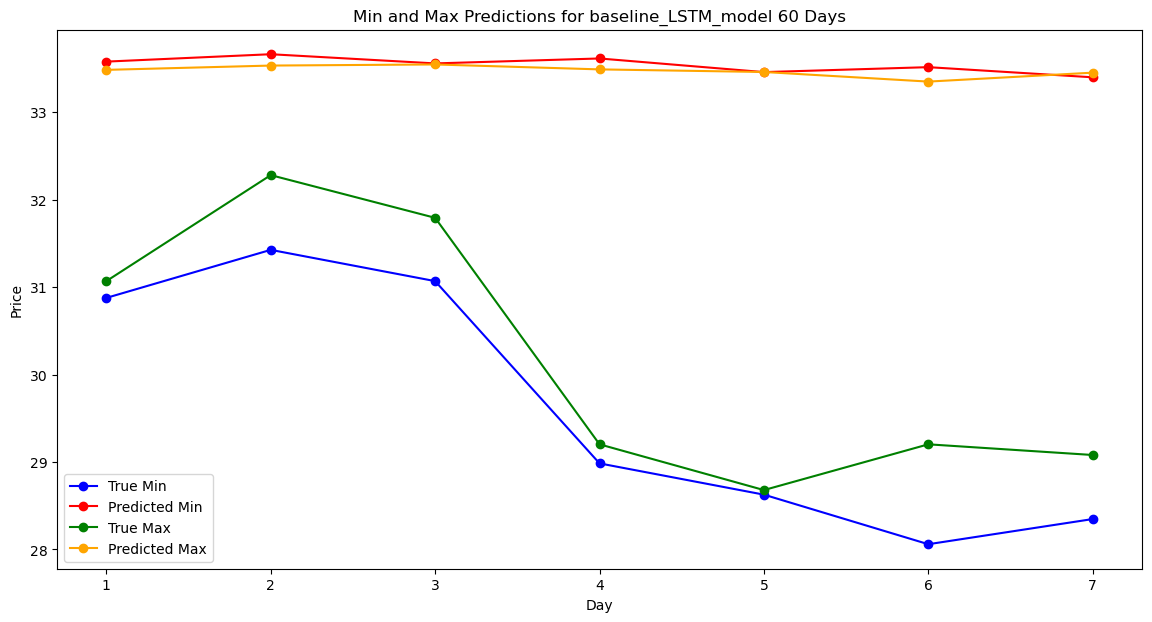

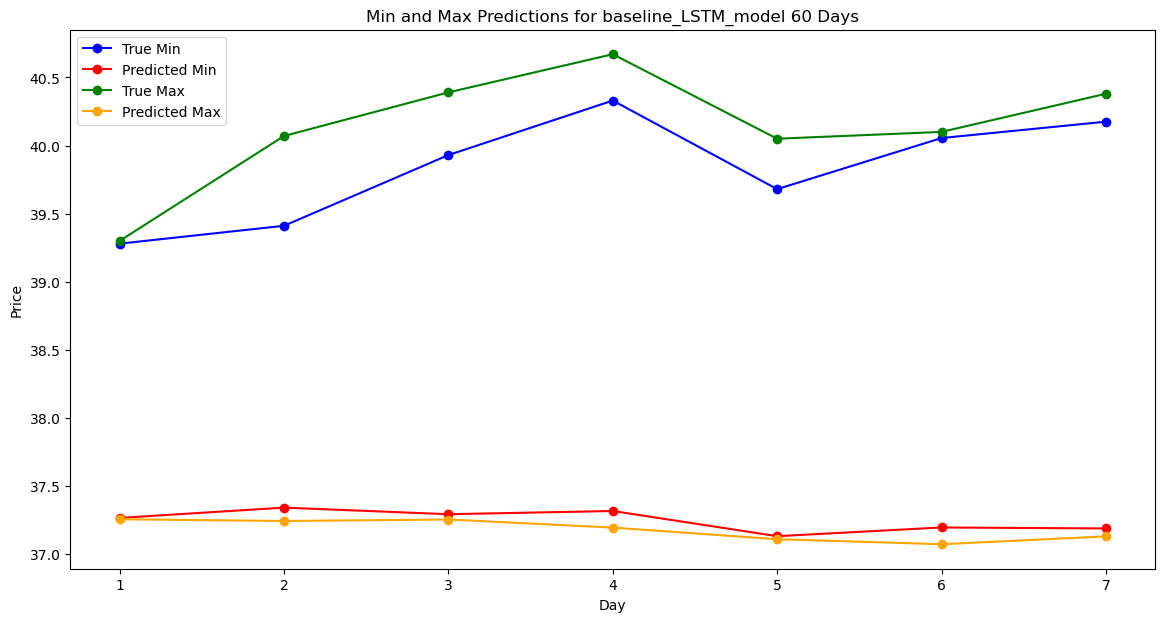

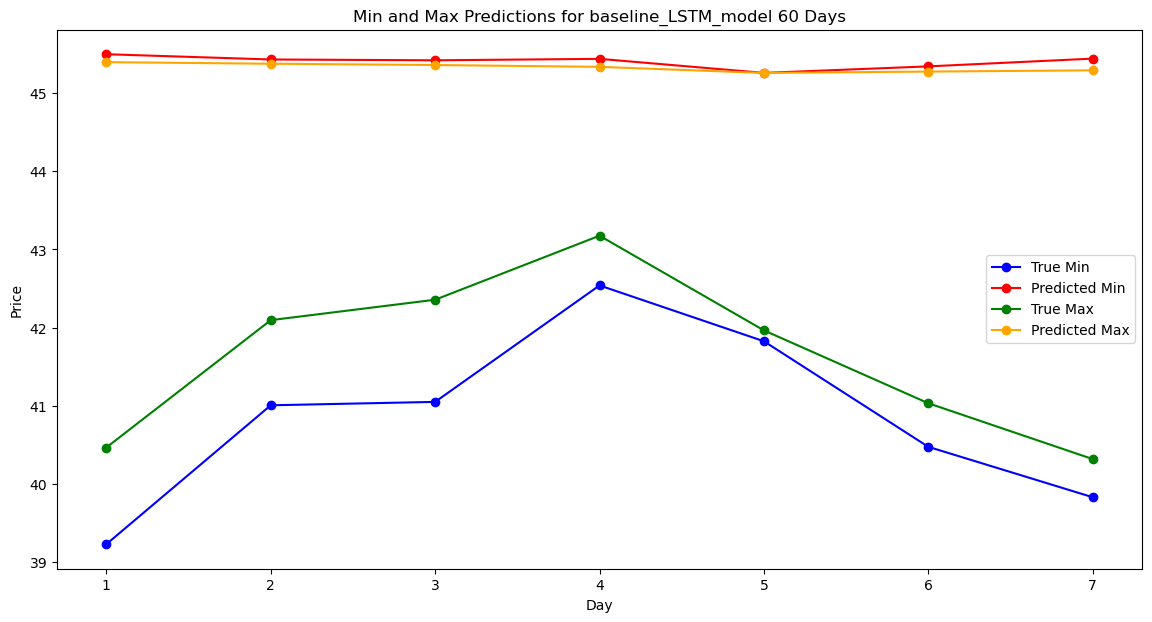

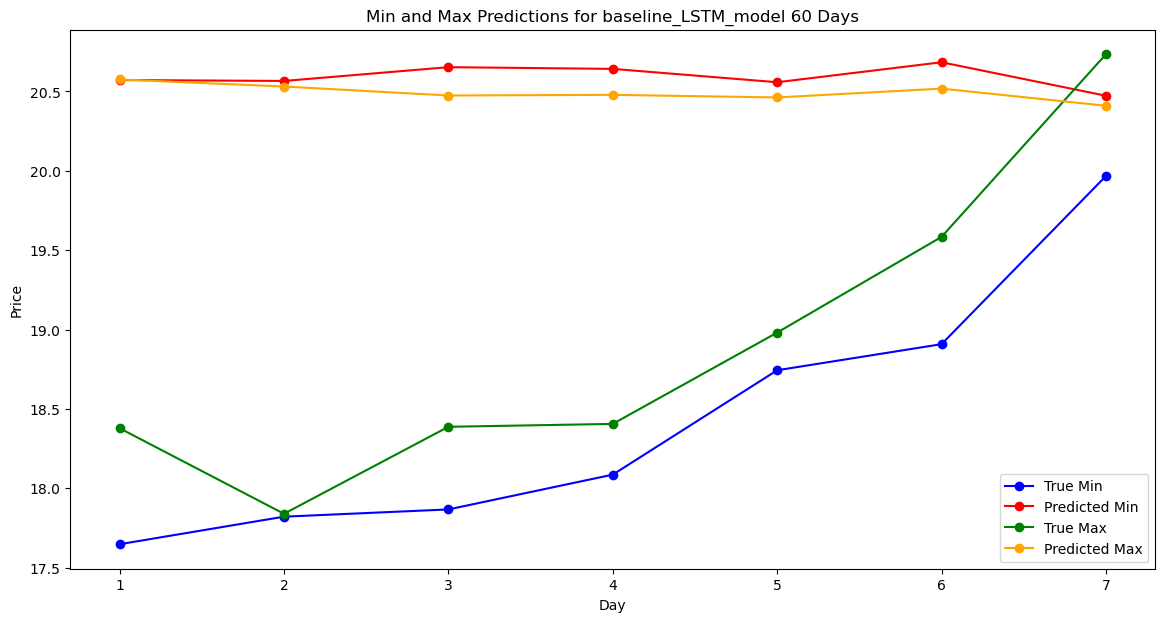

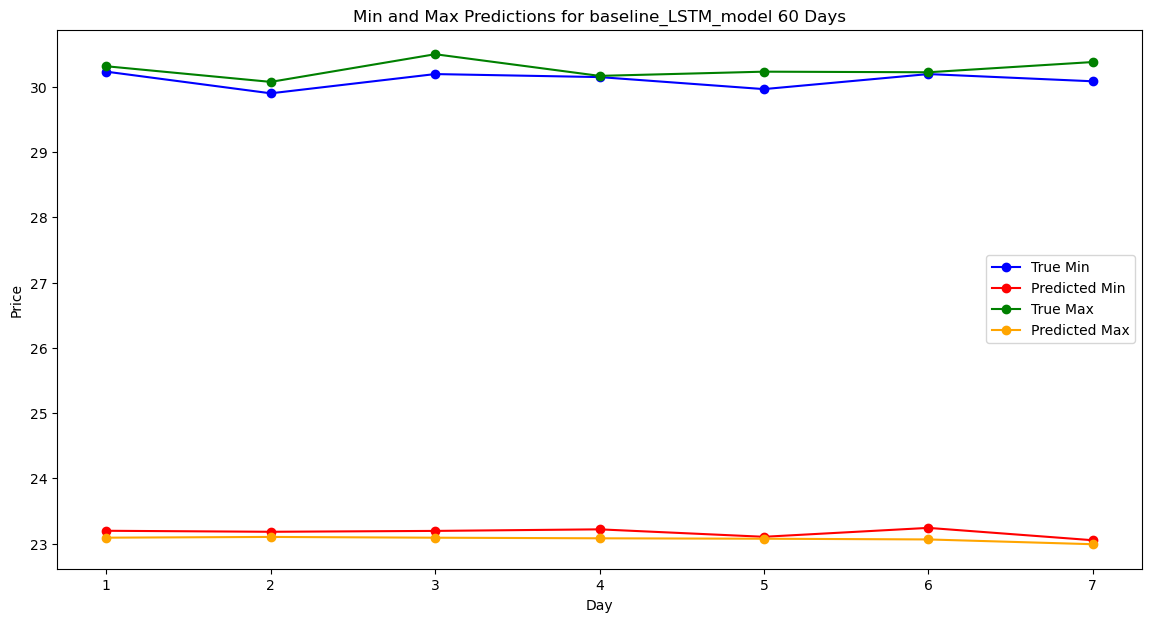

218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step


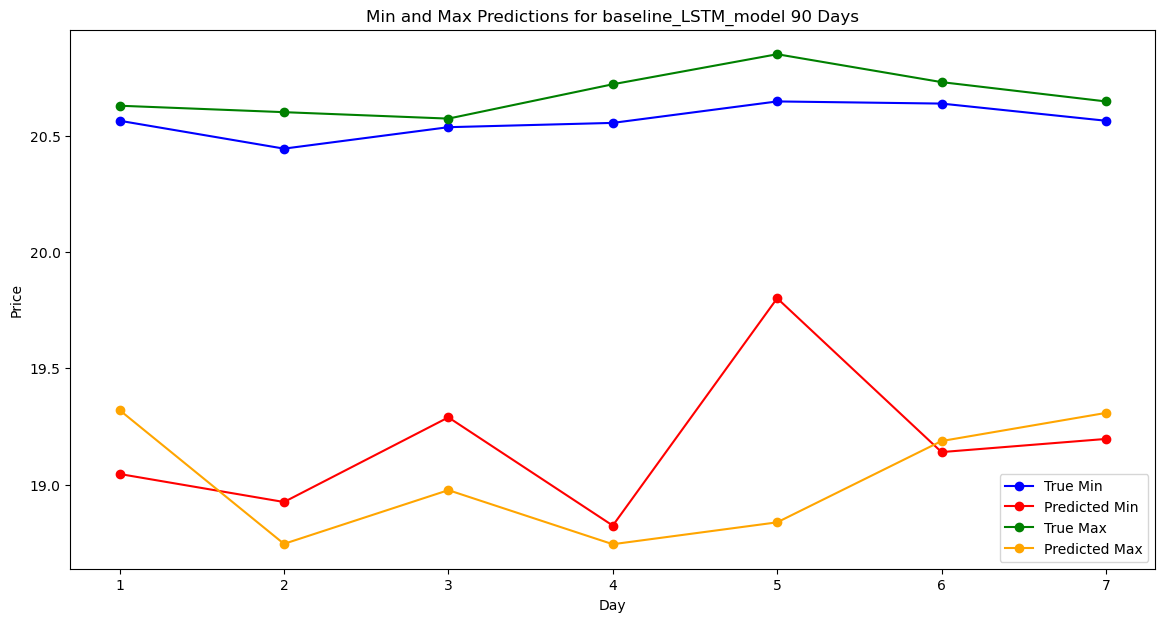

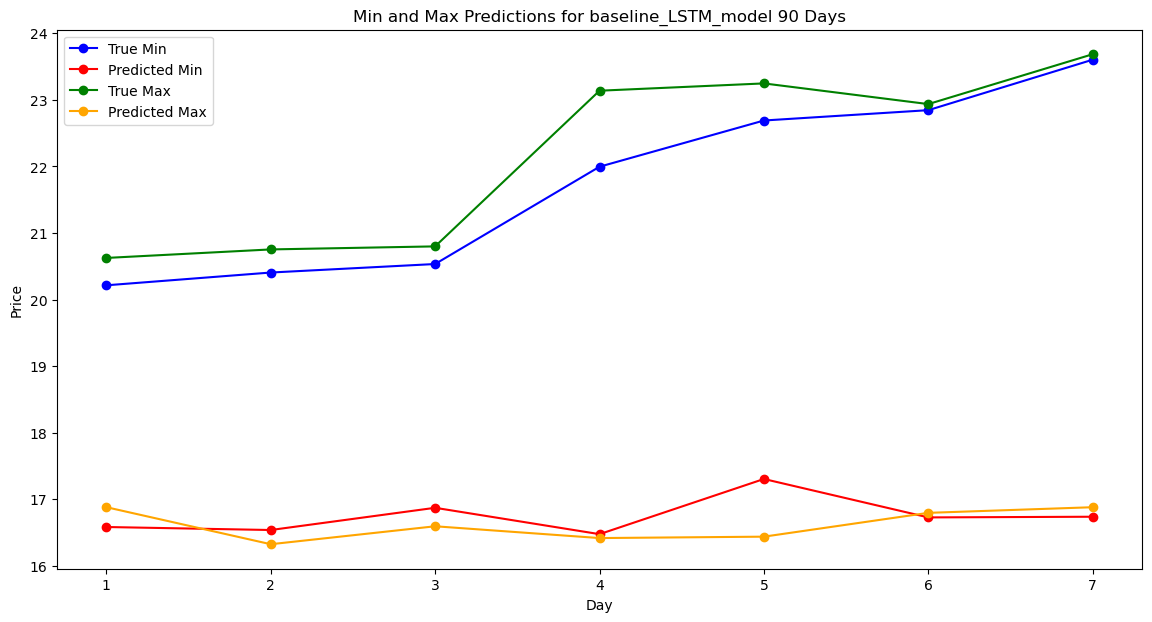

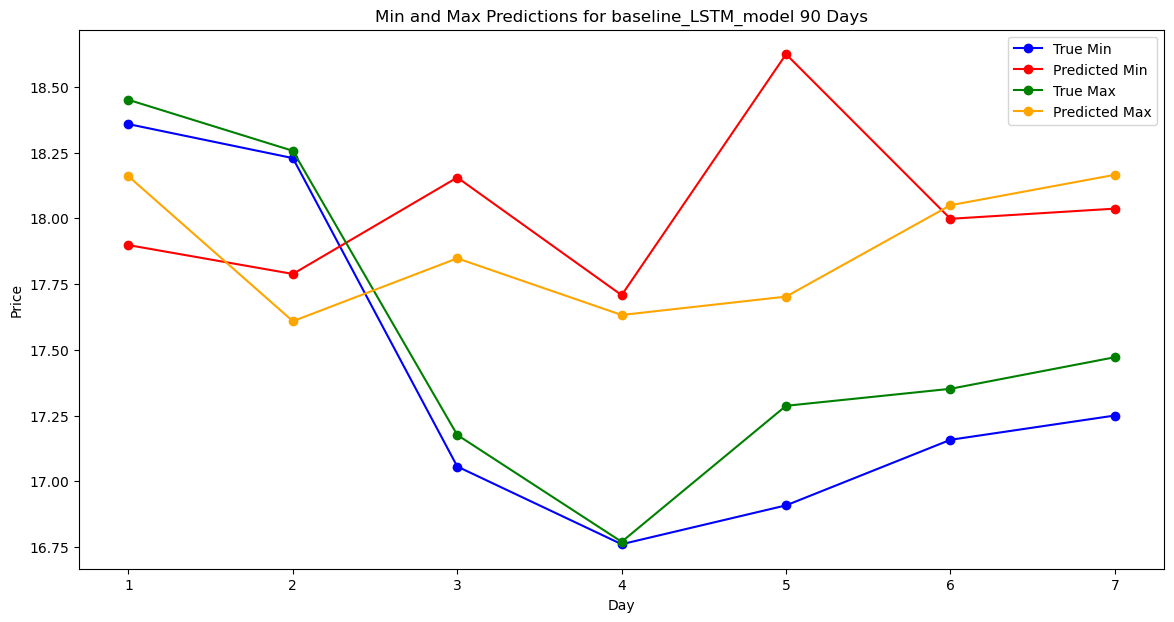

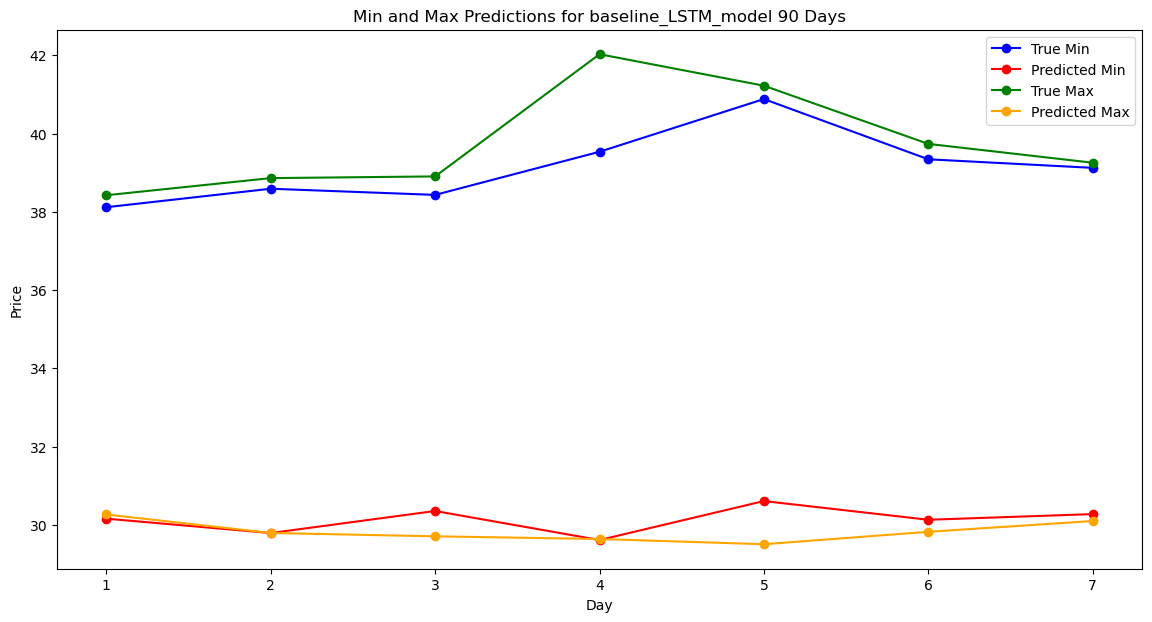

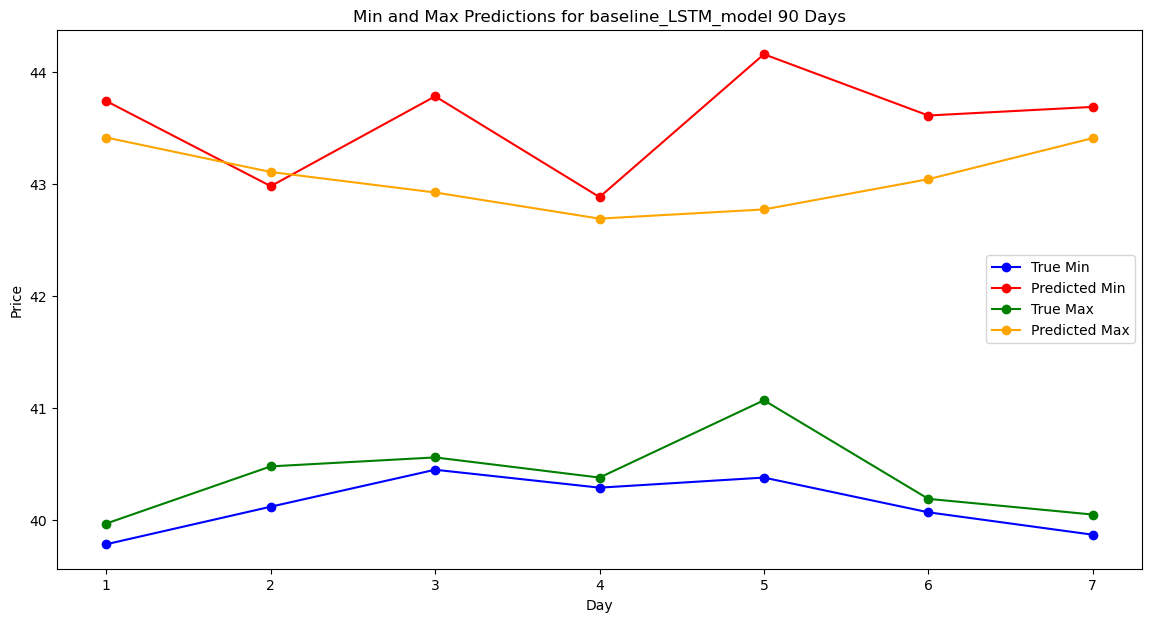

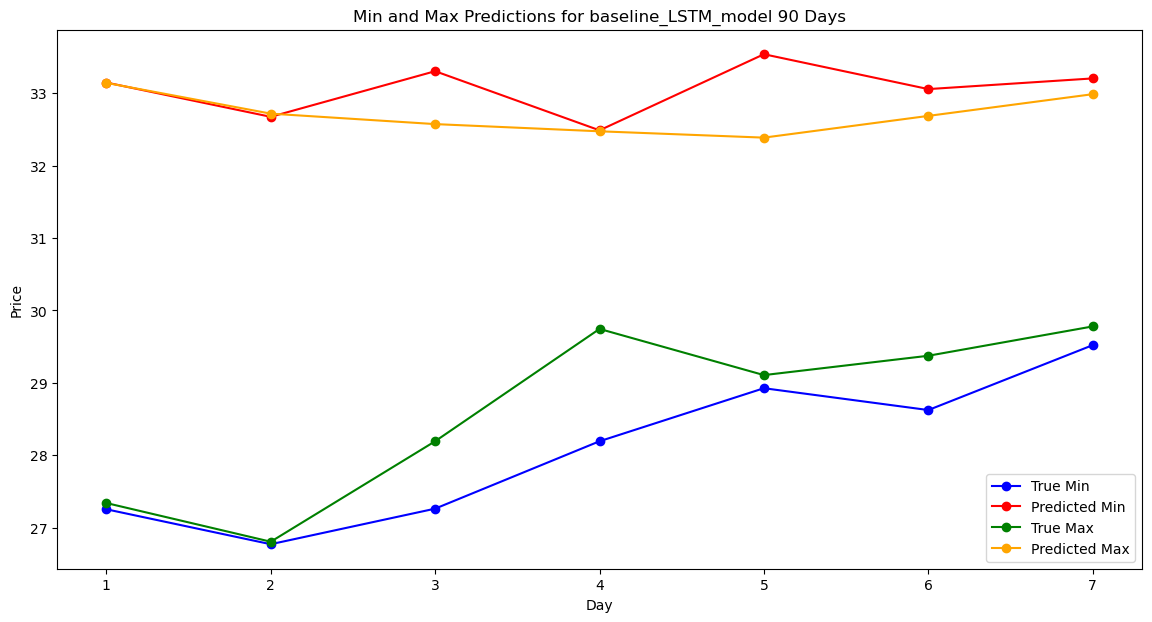

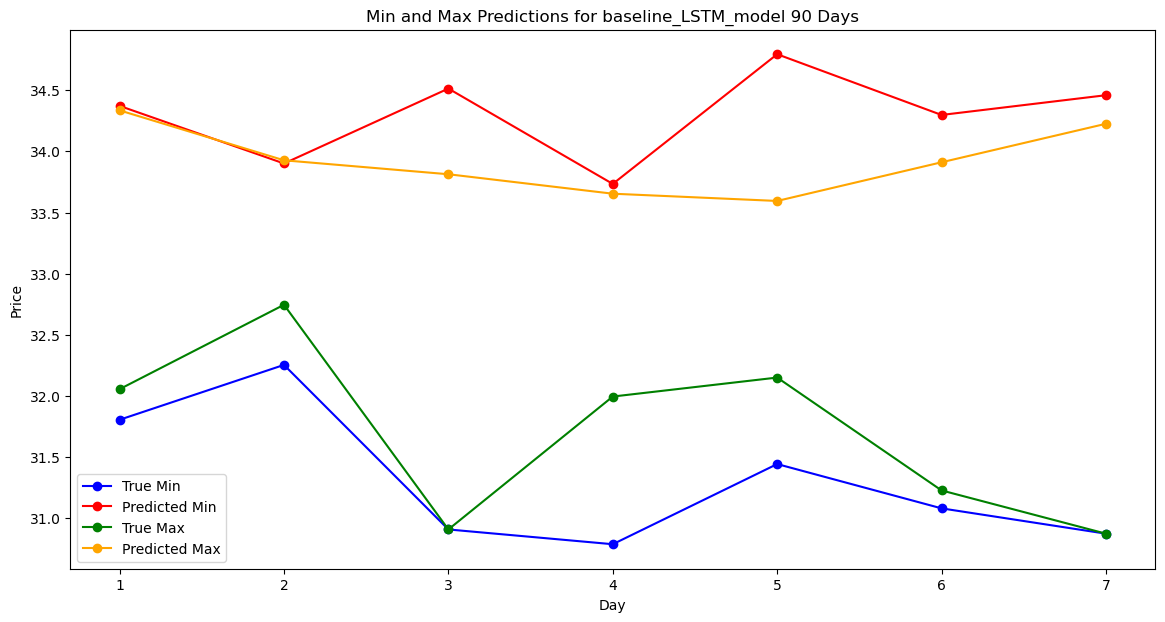

211/211 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step


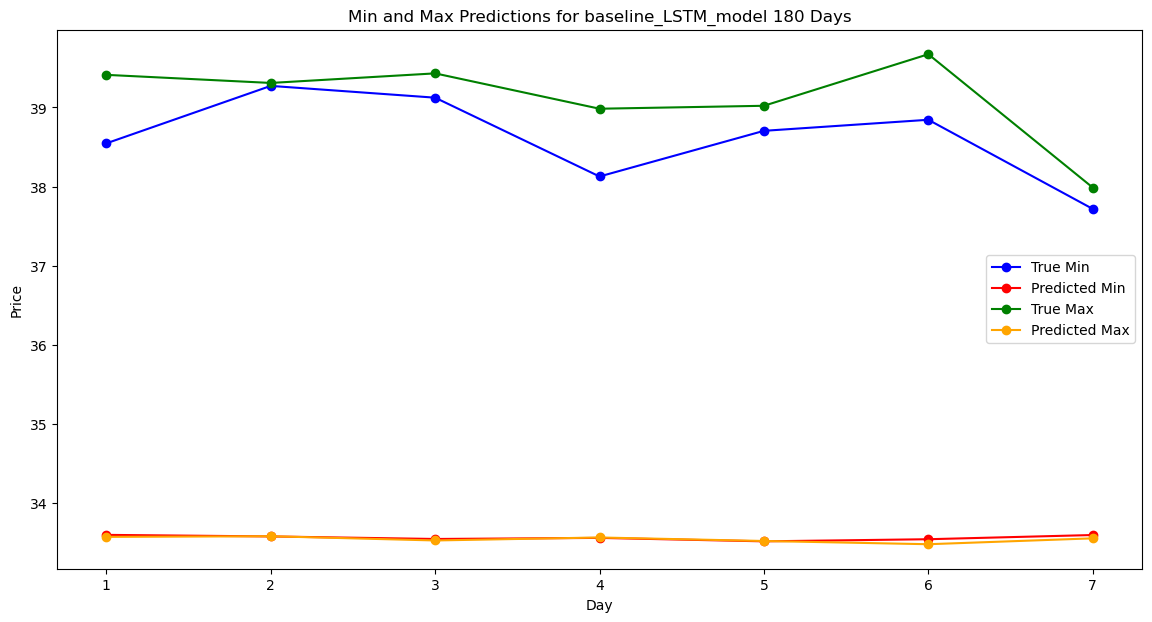

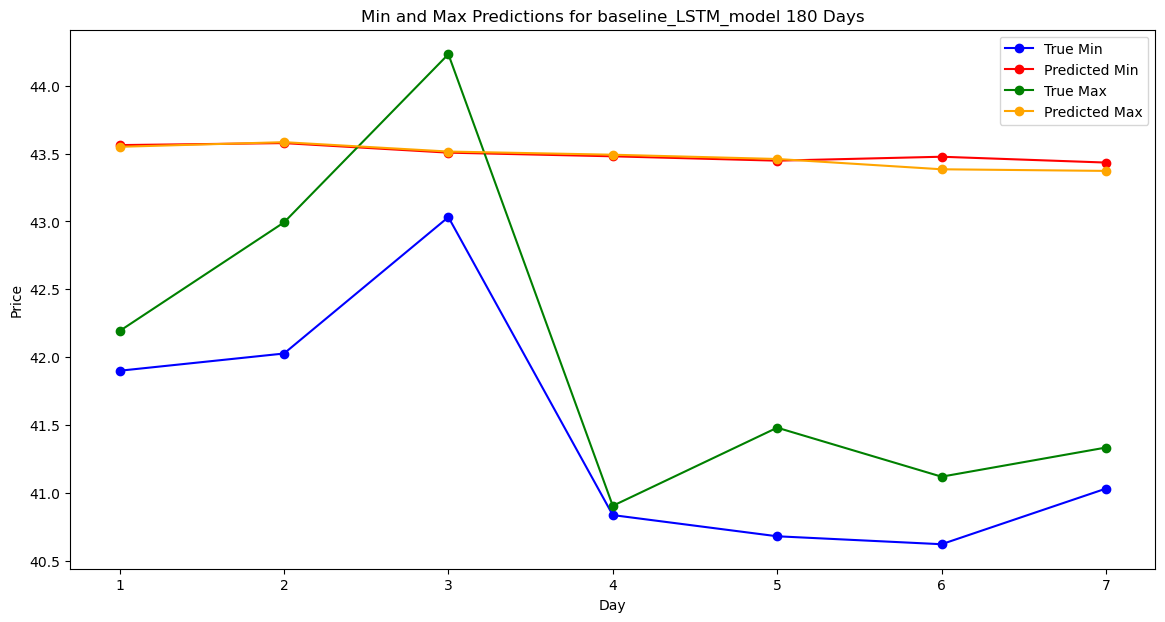

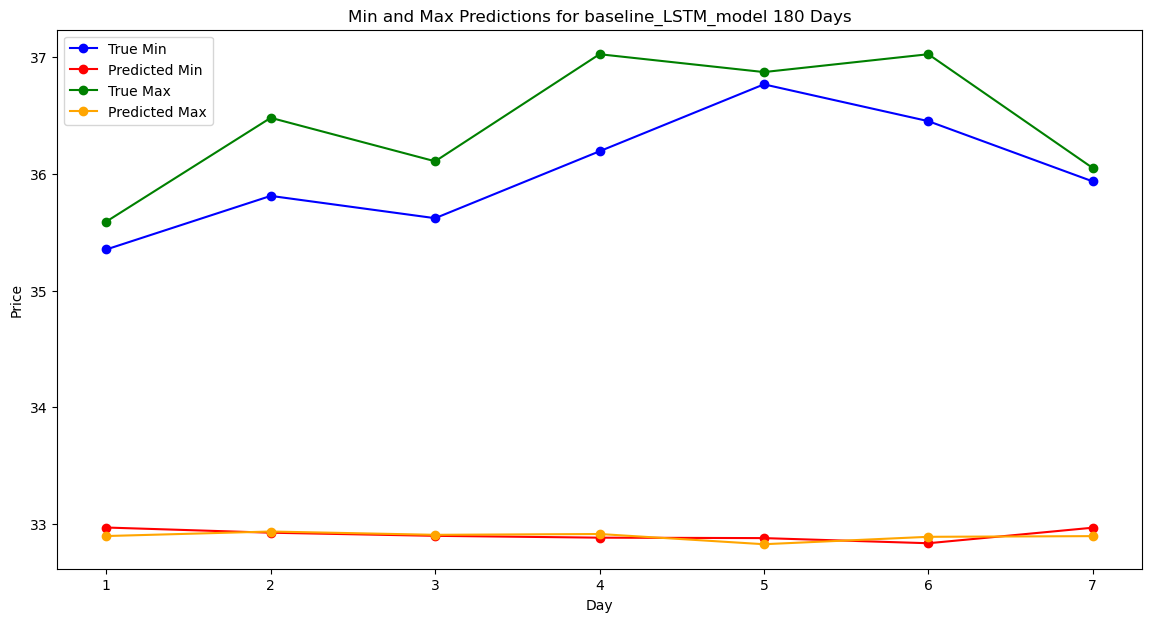

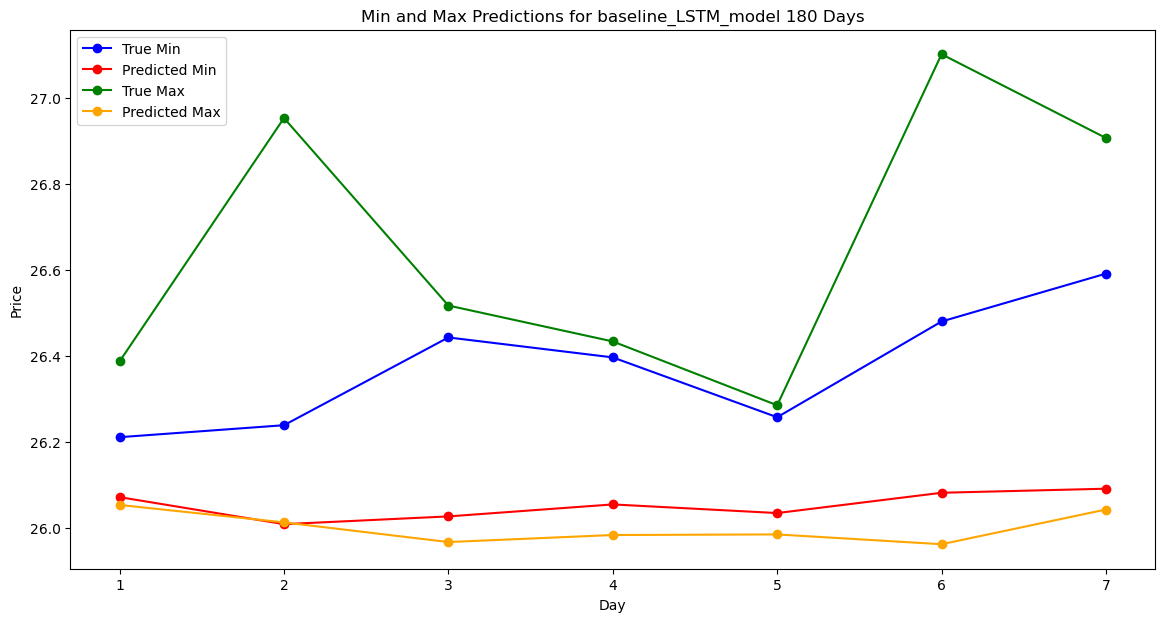

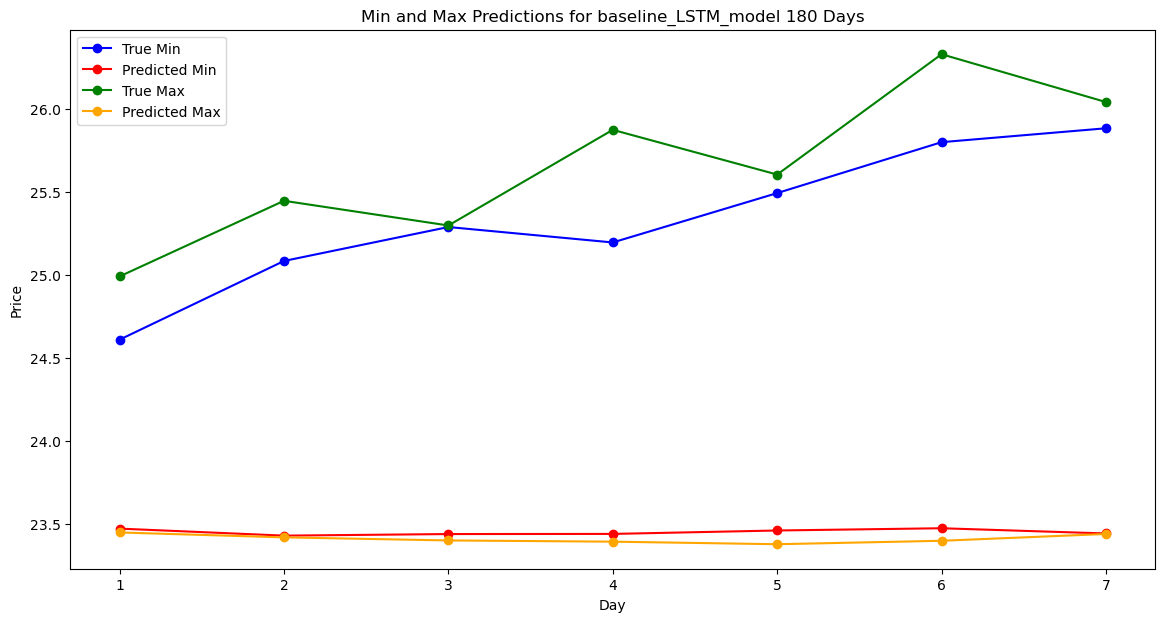

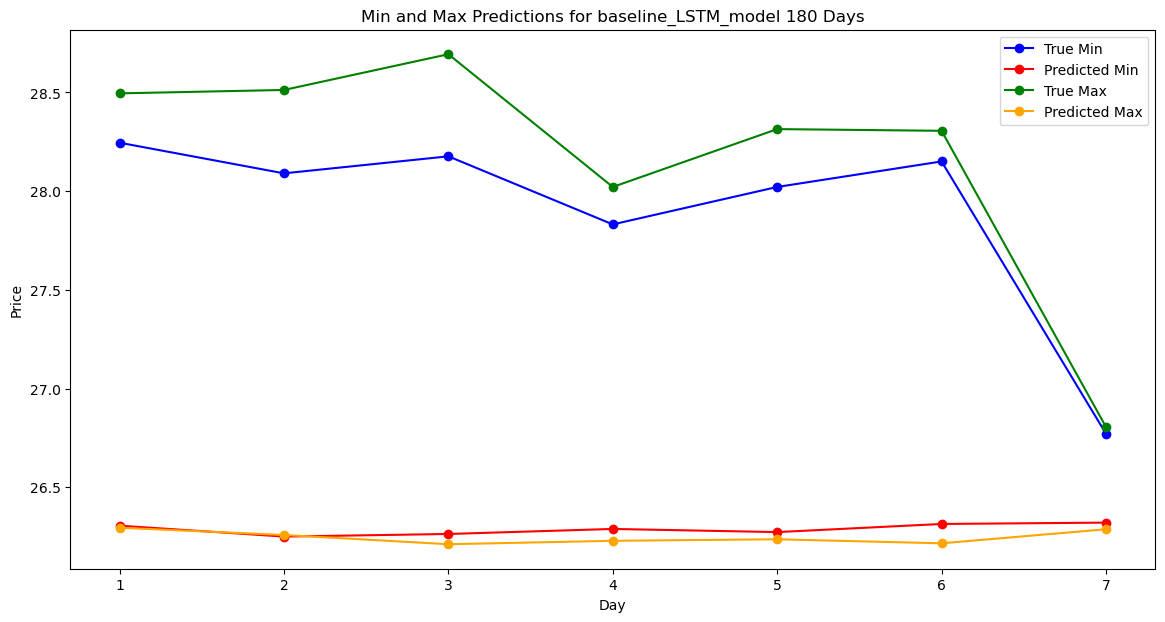

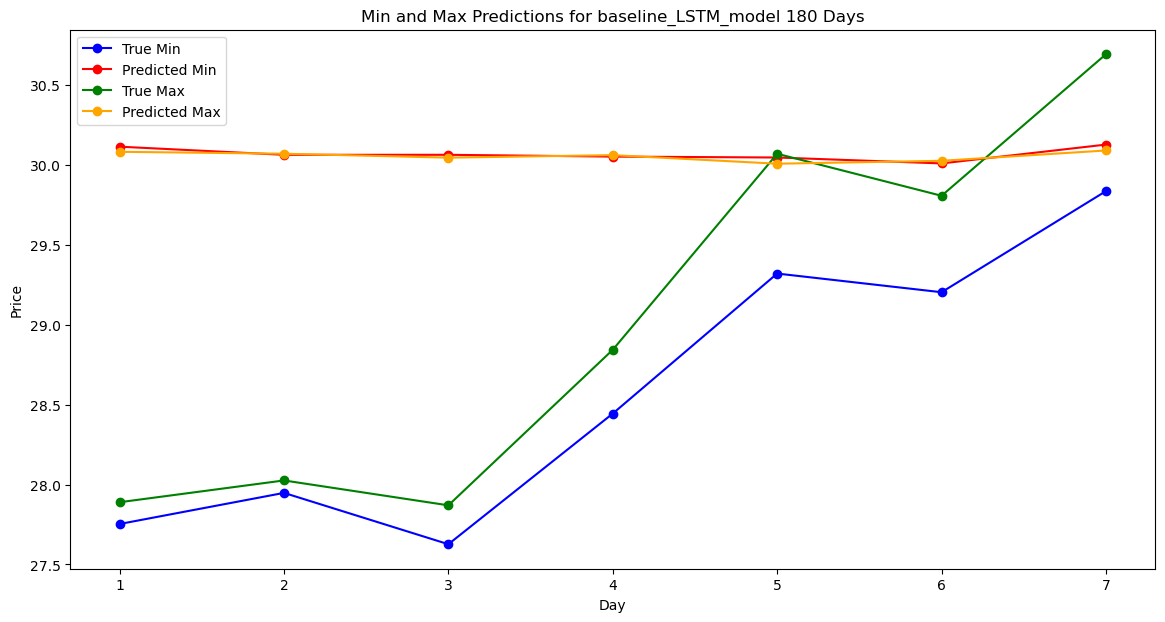

In [17]:
function_list = [baseline_LSTM_model, 
                 #baseline_GRU_model, 
                 #CNN_LSTM_model, 
                 #CNN_GRU_model, 
                 #CNN_LSTM_SA_model, 
                 #CNN_GRU_SA_model,
                 #TFT_transformer_model
                 ]
for model_function in function_list:
    models, model_history, name, X_tests, y_tests = base_training(model_function, 
                                                        loading_path = "data/", 
                                                        saving_path="saved models/",
                                                        version_name="20250204",
                                                        seed = 42,
                                                        test_size = 0.8,
                                                        epochs = 20,
                                                        batch_size = 8,
                                                        shuffle=True, 
                                                        metrics=['mae'],
                                                        #loss = 'mean_squared_error',
                                                        loss = custom_loss,
                                                        optimizer='adam',
                                                        window_size = window_size, 
                                                        num_features = num_features, 
                                                        output_days = output_days, 
                                                        output_features = output_features
                                                        )
    plot_training_history(model_history, window_size, name)
    plot_predictions(models, X_tests, y_tests, window_size, name)
    

Build ensemble model with meta mode (transfer learning/fine-tuning), since will do back propaggation through the ensemble layer all the way to the individual model, we can use multiple stock training data for the individual model, increase the generalization, and do the tuning with the target data, in the ensemble layer training part

In [18]:
from tensorflow.keras.models import Model
def ensemble_stacking (models_inputs, models_outputs, output_days, output_features, optimizer, loss, metrics):
    merged_output = layers.concatenate(models_outputs, axis=-1)
    #searching method for removing the last layer of the model, and directly inputting weight into stackinng model
    
    #stacking model
    merged_output = layers.Dense(64, activation='relu')(merged_output)
    merged_output = layers.Dense(output_days * output_features)(merged_output)
    final_output = layers.Reshape((output_days, output_features))(merged_output)
    ensemble_model = Model(inputs=models_inputs, outputs=final_output)
    ensemble_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return ensemble_model


    

In [19]:
def ensemble_weighting (models_inputs, models_outputs, output_days, output_features, optimizer, loss, metrics):
    merged_output = layers.Add()(models_outputs)
    merged_output = layers.Dense(output_days*output_features)(merged_output)
    final_output = layers.Reshape((output_days, output_features))(merged_output)
    ensemble_model = Model(inputs=models_inputs, outputs=final_output)
    ensemble_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return ensemble_model


In [20]:
#need more understanding on the MoE
''' stacking is y_p = sum(w*y_i)
    MoE is y_p = sum(g_i*y_i)
    can add other function model, like anomaly detection, to the ensemble model, since most of the data is normal, the model can be used to detect the anomaly data(Event)
'''

def ensemble_MoE(models_inputs, models_outputs, output_days, output_features, optimizer, loss, metrics):
    # Step 1: Concatenate the outputs of all the experts
    concatenated_experts = layers.concatenate(models_outputs)
    
    # Step 2: Apply a gate to weight the expert outputs
    gate = layers.Dense(len(models_outputs), activation='softmax')(concatenated_experts)
    
    # Step 3: Multiply the gate with the expert outputs
    weighted_experts = [layers.Multiply()([gate[:, i:i+1], models_outputs[i]]) for i in range(len(models_outputs))]
    
    # Step 4: Sum the weighted expert outputs
    final_expert_output = layers.Add()(weighted_experts)
    
    # Step 5: Reshape the final output to the desired shape
    final_output = layers.Reshape((output_days, output_features))(final_expert_output)

    # Step 6: Define the ensemble model
    ensemble_model = models.Model(inputs=models_inputs, outputs=final_output)

    # Step 7: Compile the model
    ensemble_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return ensemble_model

In [21]:
#function to load models in provided path
from tensorflow.keras.models import load_model
def load_models(path, remove_last_layer=True):
    orginal_models = []
    models_outputs = []
    models_inputs = []
    models_order = []
    for file in sorted(os.listdir(path)):
        if file.endswith(".h5"):
            model = load_model(os.path.join(path, file))
            models_order.append(file)
            print(f"Model loaded: {os.path.join(path, file)}")
            orginal_models.append(load_model(os.path.join(path, file), compile=False))
            if remove_last_layer:
                try:
                    output = model.layers[-2].output  # Use the second last layer as output
                    model = Model(inputs=model.input, outputs=output)
                    print(f"Removed final layer from model: {os.path.join(path, file)}")
                except Exception as e:
                    print(f"Error modifying model {os.path.join(path, file)}: {e}")
            models_inputs.append(model.input)
            print(models_inputs)
            models_outputs.append(model.output)
    
    
    return orginal_models, models_inputs, models_outputs, models_order



In [22]:
def ensemble_model_training(models_inputs, models_outputs, output_days, output_features, model_type = "stacking", optimizer='adam', loss='mean_squared_error', metrics=['mae']):
    if model_type == 'stacking':
        ensemble_model = ensemble_stacking(models_inputs, models_outputs, output_days, output_features, optimizer, loss, metrics)
    elif model_type == 'weighting':
        ensemble_model = ensemble_weighting(models_inputs, models_outputs, output_days, output_features, optimizer, loss, metrics)
    elif model_type == 'MoE':
        ensemble_model = ensemble_MoE(models_inputs, models_outputs, output_days, output_features, optimizer, loss, metrics)
    else:
        print("Please provide a valid model type.")
        return None
    return ensemble_model

In [23]:
#load the whole folder of models (you might have multiple floders of models, then need multiple load_models function and do the selection in the next cell)
orginal_models, models_inputs, models_outputs, models_order = load_models("/Users/hoyinchui/Desktop/tbot-st-ta/saved models/20250128/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam")

Model loaded: /Users/hoyinchui/Desktop/tbot-st-ta/saved models/20250128/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/CNN_GRU_SA_model_14days.h5
Removed final layer from model: /Users/hoyinchui/Desktop/tbot-st-ta/saved models/20250128/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/CNN_GRU_SA_model_14days.h5
[<KerasTensor shape=(None, 14, 8), dtype=float32, sparse=False, name=input_layer_77>]
Model loaded: /Users/hoyinchui/Desktop/tbot-st-ta/saved models/20250128/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/CNN_GRU_SA_model_30days.h5
Removed final layer from model: /Users/hoyinchui/Desktop/tbot-st-ta/saved models/20250128/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/CNN_GRU_SA_model_30days.h5
[<KerasTensor shape=(None, 14, 8), dtype=float32, sparse=False, name=input_layer_77>, <KerasTensor shape=(None, 30, 8), dtype=float32, sparse=False, name=input_layer_78>]
Model loaded: /Users/hoyinchui/Desktop/tbot-st-

Removed final layer from model: /Users/hoyinchui/Desktop/tbot-st-ta/saved models/20250128/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/CNN_GRU_model_14days.h5
[<KerasTensor shape=(None, 14, 8), dtype=float32, sparse=False, name=input_layer_77>, <KerasTensor shape=(None, 30, 8), dtype=float32, sparse=False, name=input_layer_78>, <KerasTensor shape=(None, 60, 8), dtype=float32, sparse=False, name=input_layer_79>, <KerasTensor shape=(None, 7, 8), dtype=float32, sparse=False, name=input_layer_76>, <KerasTensor shape=(None, 14, 8), dtype=float32, sparse=False, name=input_layer_69>]
Model loaded: /Users/hoyinchui/Desktop/tbot-st-ta/saved models/20250128/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/CNN_GRU_model_30days.h5
Removed final layer from model: /Users/hoyinchui/Desktop/tbot-st-ta/saved models/20250128/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/CNN_GRU_model_30days.h5
[<KerasTensor shape=(None, 14, 8), dtype=float32, spa

Model loaded: /Users/hoyinchui/Desktop/tbot-st-ta/saved models/20250128/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/CNN_LSTM_SA_model_14days.h5
Removed final layer from model: /Users/hoyinchui/Desktop/tbot-st-ta/saved models/20250128/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/CNN_LSTM_SA_model_14days.h5
[<KerasTensor shape=(None, 14, 8), dtype=float32, sparse=False, name=input_layer_77>, <KerasTensor shape=(None, 30, 8), dtype=float32, sparse=False, name=input_layer_78>, <KerasTensor shape=(None, 60, 8), dtype=float32, sparse=False, name=input_layer_79>, <KerasTensor shape=(None, 7, 8), dtype=float32, sparse=False, name=input_layer_76>, <KerasTensor shape=(None, 14, 8), dtype=float32, sparse=False, name=input_layer_69>, <KerasTensor shape=(None, 30, 8), dtype=float32, sparse=False, name=input_layer_70>, <KerasTensor shape=(None, 60, 8), dtype=float32, sparse=False, name=input_layer_71>, <KerasTensor shape=(None, 7, 8), dtype=float32, sparse=

Model loaded: /Users/hoyinchui/Desktop/tbot-st-ta/saved models/20250128/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/CNN_LSTM_model_14days.h5
Removed final layer from model: /Users/hoyinchui/Desktop/tbot-st-ta/saved models/20250128/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/CNN_LSTM_model_14days.h5
[<KerasTensor shape=(None, 14, 8), dtype=float32, sparse=False, name=input_layer_77>, <KerasTensor shape=(None, 30, 8), dtype=float32, sparse=False, name=input_layer_78>, <KerasTensor shape=(None, 60, 8), dtype=float32, sparse=False, name=input_layer_79>, <KerasTensor shape=(None, 7, 8), dtype=float32, sparse=False, name=input_layer_76>, <KerasTensor shape=(None, 14, 8), dtype=float32, sparse=False, name=input_layer_69>, <KerasTensor shape=(None, 30, 8), dtype=float32, sparse=False, name=input_layer_70>, <KerasTensor shape=(None, 60, 8), dtype=float32, sparse=False, name=input_layer_71>, <KerasTensor shape=(None, 7, 8), dtype=float32, sparse=False,

Removed final layer from model: /Users/hoyinchui/Desktop/tbot-st-ta/saved models/20250128/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/baseline_GRU_model_14days.h5
[<KerasTensor shape=(None, 14, 8), dtype=float32, sparse=False, name=input_layer_77>, <KerasTensor shape=(None, 30, 8), dtype=float32, sparse=False, name=input_layer_78>, <KerasTensor shape=(None, 60, 8), dtype=float32, sparse=False, name=input_layer_79>, <KerasTensor shape=(None, 7, 8), dtype=float32, sparse=False, name=input_layer_76>, <KerasTensor shape=(None, 14, 8), dtype=float32, sparse=False, name=input_layer_69>, <KerasTensor shape=(None, 30, 8), dtype=float32, sparse=False, name=input_layer_70>, <KerasTensor shape=(None, 60, 8), dtype=float32, sparse=False, name=input_layer_71>, <KerasTensor shape=(None, 7, 8), dtype=float32, sparse=False, name=input_layer_68>, <KerasTensor shape=(None, 14, 8), dtype=float32, sparse=False, name=input_layer_73>, <KerasTensor shape=(None, 30, 8), dtype=float32, sp

Model loaded: /Users/hoyinchui/Desktop/tbot-st-ta/saved models/20250128/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/baseline_LSTM_model_7days.h5
Removed final layer from model: /Users/hoyinchui/Desktop/tbot-st-ta/saved models/20250128/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/baseline_LSTM_model_7days.h5
[<KerasTensor shape=(None, 14, 8), dtype=float32, sparse=False, name=input_layer_77>, <KerasTensor shape=(None, 30, 8), dtype=float32, sparse=False, name=input_layer_78>, <KerasTensor shape=(None, 60, 8), dtype=float32, sparse=False, name=input_layer_79>, <KerasTensor shape=(None, 7, 8), dtype=float32, sparse=False, name=input_layer_76>, <KerasTensor shape=(None, 14, 8), dtype=float32, sparse=False, name=input_layer_69>, <KerasTensor shape=(None, 30, 8), dtype=float32, sparse=False, name=input_layer_70>, <KerasTensor shape=(None, 60, 8), dtype=float32, sparse=False, name=input_layer_71>, <KerasTensor shape=(None, 7, 8), dtype=float32, spars

In [24]:
#select the models(4 models Time-based) and ensemble method you want and feed into the ensemble traing function
#if stargetry changed, the function and training set need to updatye too 
print(models_order)

['CNN_GRU_SA_model_14days.h5', 'CNN_GRU_SA_model_30days.h5', 'CNN_GRU_SA_model_60days.h5', 'CNN_GRU_SA_model_7days.h5', 'CNN_GRU_model_14days.h5', 'CNN_GRU_model_30days.h5', 'CNN_GRU_model_60days.h5', 'CNN_GRU_model_7days.h5', 'CNN_LSTM_SA_model_14days.h5', 'CNN_LSTM_SA_model_30days.h5', 'CNN_LSTM_SA_model_60days.h5', 'CNN_LSTM_SA_model_7days.h5', 'CNN_LSTM_model_14days.h5', 'CNN_LSTM_model_30days.h5', 'CNN_LSTM_model_60days.h5', 'CNN_LSTM_model_7days.h5', 'baseline_GRU_model_14days.h5', 'baseline_GRU_model_30days.h5', 'baseline_GRU_model_60days.h5', 'baseline_GRU_model_7days.h5', 'baseline_LSTM_model_14days.h5', 'baseline_LSTM_model_30days.h5', 'baseline_LSTM_model_60days.h5', 'baseline_LSTM_model_7days.h5']


In [25]:
#be aware of the order, it need to be 7, 14, 30, 60 from small to large
models_inputs_selected = [models_inputs[3], models_inputs[0], models_inputs[1], models_inputs[2]]   
models_outputs_selected = [models_outputs[3], models_outputs[0], models_outputs[1], models_outputs[2]]

In [26]:
#select the models(4 models Time-based) and ensemble method you want and feed into the ensemble traing function
#if stargetry changed, the function and training set need to updatye too 
ensemble_s_model = ensemble_model_training(models_inputs_selected, models_outputs_selected, output_days, output_features, model_type = "stacking", optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [27]:
ensemble_w_model = ensemble_model_training(models_inputs_selected, models_outputs_selected, output_days, output_features, model_type = "weighting", optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [28]:
ensemble_MoE_model = ensemble_model_training(models_inputs_selected, models_outputs_selected, output_days, output_features, model_type = "MoE", optimizer='adam', loss='mean_squared_error', metrics=['mae'])

AttributeError: 'list' object has no attribute 'Model'

In [100]:
#loading the data for testing in ensemble model

def load_data(window_size = window_size, path = f"/Users/hoyinchui/Desktop/tbot-st-ta/Testing data/GLD_model_testing_data_pre_ens_Ai1_v3_pkl", test_size = 0.8, shuffle = True, seed = 42):
    all_X_train = []
    all_X_test = []
    all_y_train = []
    all_y_test = []
    
    y = pd.read_pickle(f"{path}/y_a.pkl")
    for window in window_size:
        X = pd.read_pickle(f"{path}/X_{window}days_a.pkl")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=shuffle, random_state=seed)
        all_X_train.append(X_train)
        all_X_test.append(X_test)
        all_y_train.append(y_train)
        all_y_test.append(y_test)
    return all_X_train, all_X_test, all_y_train, all_y_test

In [119]:
all_X_train, all_X_test, all_y_train, all_y_test = load_data(path = f"/Users/hoyinchui/Desktop/tbot-st-ta/Testing data/GLD_model_testing_data_pre_ens_Ai1_v3_pkl", test_size = 0.8, shuffle = True, seed = 42)

In [152]:
#fit the ensemble model
def ensemble_model_fit(ensemble_model, all_X_train, all_y_train, epochs, batch_size, save_model_path, folder_name):
    history = ensemble_model.fit(all_X_train, all_y_train[0], epochs=epochs, batch_size=batch_size, verbose=1)
    #create floder to save the model
    save_model_path = os.path.join(save_model_path, folder_name)
    # Save the model
    params = f"ensemble_e-{epochs}_b-{batch_size}"
    os.makedirs(os.path.join(save_model_path, params ), exist_ok=True)
    name = ensemble_model.name
    ensemble_model.save(os.path.join(os.path.join(save_model_path, folder_name, params ),f"{name}.h5"))
    return history

In [153]:
#traing the ensemble model
ensemble_s_model_history = ensemble_model_fit( ensemble_s_model, all_X_train, all_y_train, epochs = 20, batch_size = 8, save_model_path = "/Users/hoyinchui/Desktop/tbot-st-ta/saved models",folder_name  = "20250202")


Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.7000e-04 - mae: 0.0122
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.9753e-04 - mae: 0.0126
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.5256e-04 - mae: 0.0116
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.4424e-04 - mae: 0.0114
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.6069e-04 - mae: 0.0120
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.5150e-04 - mae: 0.0116
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.6657e-04 - mae: 0.0144
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.3350e-04 - mae: 0.0113
Epoch 9/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.0335e-04 - mae: 0.0132
Epoch 10/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.5268e-04 - mae: 0.0118
Epoch 11/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.2285e-04 - mae: 0.0110
Epoch 12/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/ste

### the following 3 cell can skip, theey are old version for reference

In [ ]:
#load the model and predict and save the prediction
#for window in window_size:
#    model = tf.keras.models.load_model(f"CNN_LSTM_{window}days.h5")
#    y_pred = model.predict(X_test)
#    pd.DataFrame(y_pred).to_csv(f"y_pred_CNN_LSTM_{window}days.csv")

In [ ]:
#putting all windows prediction into the dataframe as X
#import numpy as np
#X_ensemble = pd.DataFrame()
#for window in window_size:
#    X_ensemble = pd.concat([X_ensemble, pd.read_csv(f"y_pred_CNN_LSTM_{window}days.csv")], axis=1)
#    #combein the columns, so that can be used as input for the ensemble model
#   X_ensemble = X_ensemble.applymap(lambda x: np.vstack(x))

They can combein in 1 for loop, I just split it for clear

In [ ]:
#def train_test_split_ensemble(X,y,test_size=0.5, seed=42):    
#    #split again for the prediction model and the ensemble model
#    #Since we already shuffled the data, we can just split the data in half, and easaier to manage
#    X_train_ensemble, X_test_ensemble, y_train_ensemble, y_test_ensemble = train_test_split(X, y, test_size=test_size, shuffle=False, random_state=seed)
#    return X_train_ensemble, X_test_ensemble, y_train_ensemble, y_test_ensemble

In [ ]:
#X_train_ensemble, X_test_ensemble, y_train_ensemble, y_test_ensemble = train_test_split_ensemble(X_ensemble, y_test)

### Ensemble Model (TBC)

In [3]:
#from tensorflow.keras.models import Model
#def ensemble_CNN_LSTM(window_size, num_features):
#    inputs = layers.Input(shape=(window_size, num_features))
#    x = layers.Conv1D(filters=64, kernel_size=2, activation='relu')(inputs)
#    x = layers.MaxPooling1D(pool_size=2)(x)
#    x = layers.Conv1D(filters=128, kernel_size=2, activation='relu')(x)
#    x = layers.MaxPooling1D(pool_size=2)(x)
#    x = layers.LSTM(100)(x)
#    model = Model(inputs=inputs, outputs=x)
#    return model

In [ ]:
#def ensemble_s_models(window_size, num_features, output_days, output_features):
#        models = []
#    for window in window_size:
#        model = ensemble_CNN_LSTM(window, num_features)
#        models.append(model)

In [ ]:
#def ensemble_MoE_models(window_size, num_features, output_days, output_features):


In [4]:
#def ensemble_h_models(window_size, num_features, output_days, output_features):
#    models = []
#    for window in window_size:
#        model = ensemble_CNN_LSTM(window, num_features)
#        models.append(model)
#    models_inputs = [model.input for model in models]
#    models_outputs = [model.output for model in models]
#   merged = layers.concatenate(models_outputs, axis=-1)
#    merged_output = layers.Dense(output_days * output_features)(merged)
#    final_output = layers.Reshape((output_days, output_features))(merged_output)
#    ensemble_model = Model(inputs=models_inputs, outputs=final_output)
#    ensemble_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
#
#    return ensemble_model

In [6]:
#from sklearn.model_selection import train_test_split
#import pandas as pd
#seed = 42
#test_size = 0.8 # we need to consider for the ensemble model's training and ttesting data, since it cannot use the same training data
#epochs = 20
#batch_size = 8
#shuffle=True
#all_X_train = []
#all_X_test = []
#all_y_train = []
#all_y_test = []
#
#y = pd.read_pickle(f"/Users/hoyinchui/Downloads/y_a.pkl")
#for window in window_size:
#    X = pd.read_pickle(f"/Users/hoyinchui/Downloads/X_{window}days_a.pkl")
#    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=shuffle, random_state=seed)
#    all_X_train.append(X_train)
#    all_X_test.append(X_test)
#    all_y_train.append(y_train)
#    all_y_test.append(y_test)
#
##ensemble_model = ensemble_h_models(window_size, num_features, output_days, output_features)
##history = ensemble_model.fit(all_X_train, all_y_train[0], epochs=epochs, batch_size=batch_size, validation_data=(all_X_test, all_y_test[0]), verbose=1)
##ensemble_model.save(f"ensemble_CNN_LSTM.h5")
#

Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0279 - mae: 0.1027 - val_loss: 5.5140e-04 - val_mae: 0.0176
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 5.2824e-04 - mae: 0.0169 - val_loss: 4.1390e-04 - val_mae: 0.0154
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 5.1239e-04 - mae: 0.0167 - val_loss: 4.6971e-04 - val_mae: 0.0162
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 4.3028e-04 - mae: 0.0155 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 7.6607e-04 - mae: 0.0210 - val_loss: 4.8477e-04 - val_mae: 0.0170
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 4.1826e-04 - mae: 0.0152 - val_loss: 3.3729e-04 - val_mae: 0.0135
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 3.9106e-04 - mae: 0.0147 - val_loss: 5.9622e-04 - val_mae: 0.0190
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 3.8556e-04 - mae: 0.0144 - val_loss: 3.2576e-04 - val_mae: